# Pre-requisite




## Import Libraries


In [86]:
# Comment out the pip requirement on google colab
# !pip install -r requirements.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Final
import sklearn
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.stattools import acf, pacf


## Load The Data

In [87]:
df = pd.read_csv('https://raw.githubusercontent.com/demilade27/Predicting-Monthly-Excess-Returns-of-Market-Index/d2f2cb8478612fa4e8fd4e87628375d44f6cb72e/data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
DF_FINAL: Final = df 

# Analyse the dataset

## Generate descriptive statistics

In [88]:
df.describe()

,dfy,infl,svar,de,lty,tms,tbl,dfr,dp,dy,ltr,ep,b/m,ntis,mr,R
count,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000,1152.000000
mean,0.011160,0.002473,0.002916,-0.647478,0.049656,0.016725,0.032931,0.000452,-3.408696,-3.403723,0.004489,-2.761218,0.552159,0.015991,0.009476,0.006740
std,0.006781,0.005266,0.005998,0.327729,0.028082,0.012924,0.030649,0.014086,0.476560,0.474459,0.024952,0.420533,0.268291,0.025712,0.054315,0.054449
min,0.003200,-0.020548,0.000072,-1.244209,0.006200,-0.036500,0.000100,-0.097600,-4.523640,-4.530894,-0.112400,-4.836478,0.120510,-0.055954,-0.287461,-0.287761
25%,0.007000,0.000000,0.000695,-0.869874,0.027400,0.008200,0.003800,-0.005100,-3.846171,-3.837780,-0.007625,-2.986049,0.323772,0.003618,-0.016829,-0.019785
50%,0.009000,0.002422,0.001269,-0.636276,0.041000,0.017050,0.027750,0.000600,-3.374832,-3.366197,0.003000,-2.810399,0.529101,0.015954,0.012951,0.010006
75%,0.013025,0.005098,0.002491,-0.501965,0.067325,0.025700,0.050700,0.005900,-3.043790,-3.039180,0.016100,-2.481701,0.738709,0.027028,0.038927,0.035815
max,0.056400,0.058824,0.073153,1.379530,0.148200,0.045500,0.163000,0.073700,-1.873246,-1.912904,0.152300,-1.774952,2.028478,0.177040,0.414312,0.413312


## Check for null or zero values
*Analysis*
---
There are no null values in the dataset
Analysing the dataset values there are zero values
* INFL: There are 239 zero values showing signs of Deflationary Stagnation
* DE:
* LTR:
* TMS:
* DFR:

In [89]:
print(df.isnull().sum())
print(df.duplicated().sum())
print((df == 0).sum())

dfy     0
infl    0
svar    0
de      0
lty     0
tms     0
tbl     0
dfr     0
dp      0
dy      0
ltr     0
ep      0
b/m     0
ntis    0
mr      0
R       0
dtype: int64
0
dfy       0
infl    239
svar      0
de        1
lty       0
tms       1
tbl       0
dfr       9
dp        0
dy        0
ltr       4
ep        0
b/m       0
ntis      0
mr        0
R         0
dtype: int64


#Analysing the data distribution


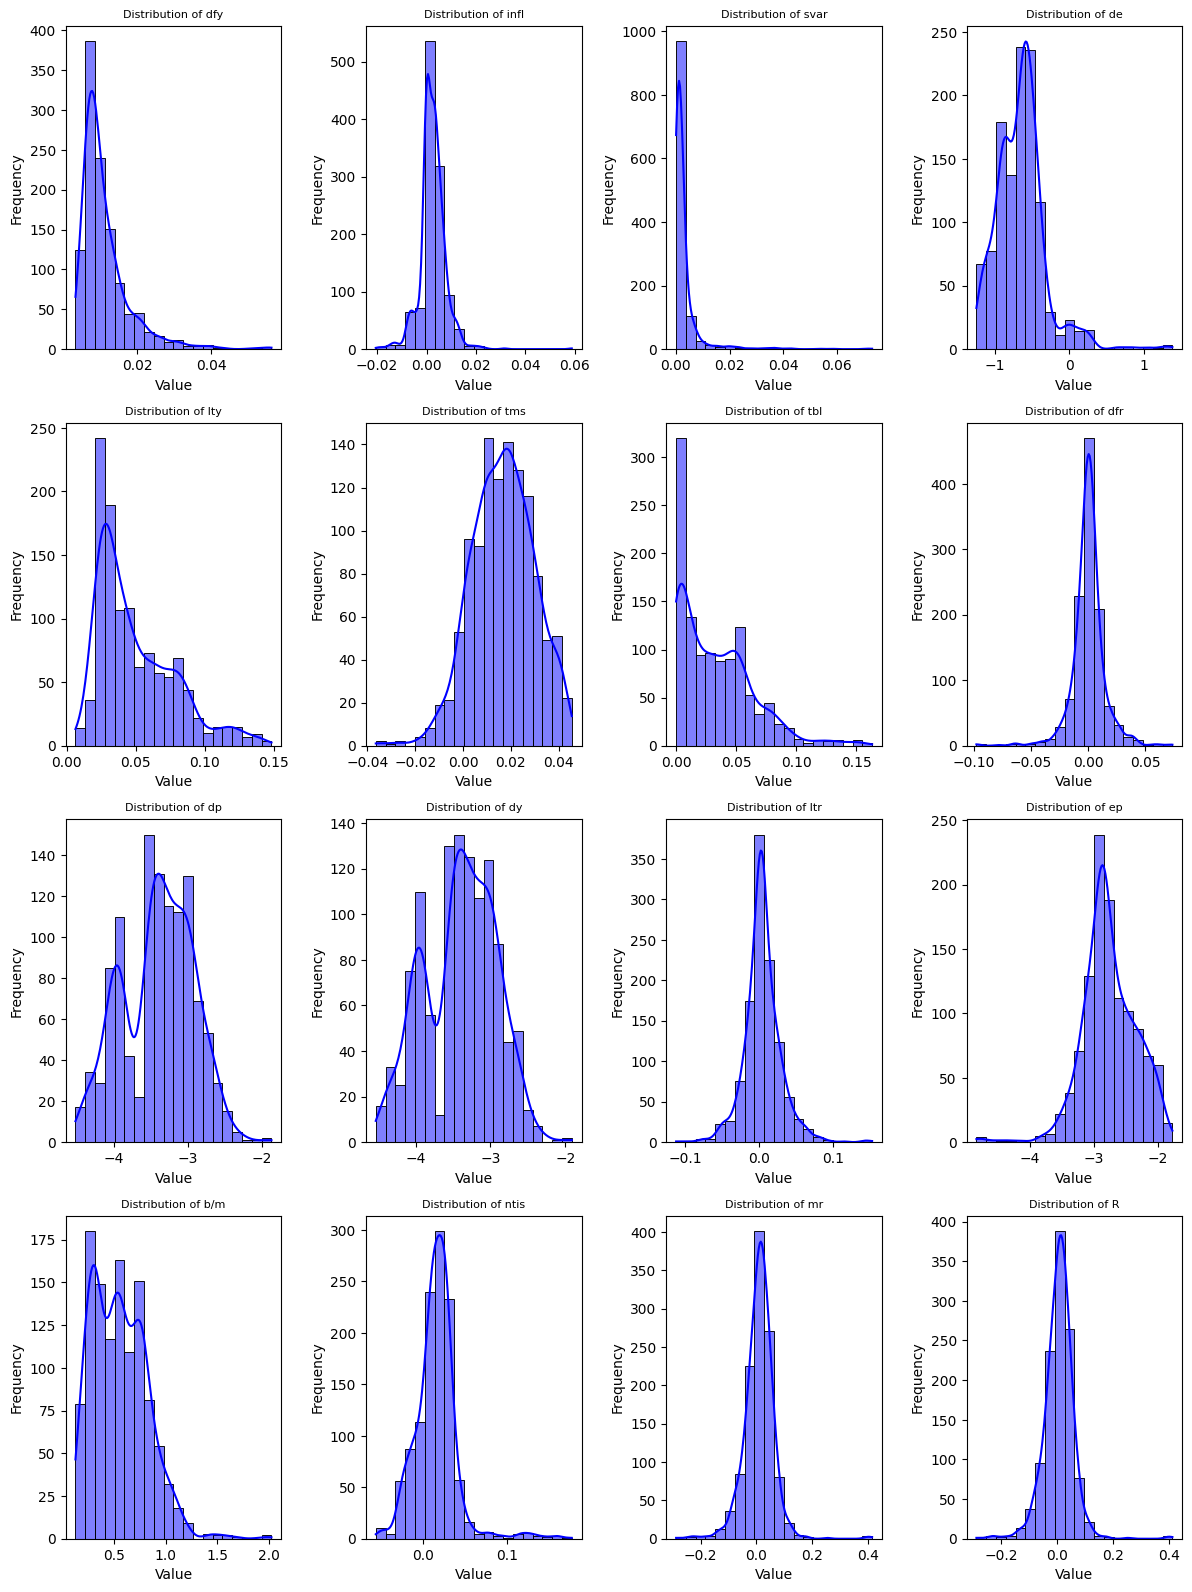

In [90]:
columns=df.select_dtypes(include=['float64','int64']).columns
n_cols=4
n_rows=int(np.ceil(len(columns)/n_cols))

fig,axes=plt.subplots(n_rows,n_cols,figsize=(12,n_rows*4))
axes=axes.flatten()

for i, column in enumerate(columns):
  sns.histplot(df[column],kde=True,ax=axes[i],color='blue',bins=20)
  axes[i].set_title(f'Distribution of {column}',fontsize=8)
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Frequency')

plt.tight_layout(pad=1.0)
plt.show()

## Analyse Data Skewness & kurtosis

In [91]:
df.skew()

dfy     2.554524
infl    1.056650
svar    6.219337
de      1.511733
lty     1.095245
tms    -0.211256
tbl     1.134915
dfr    -0.597824
dp     -0.148801
dy     -0.173086
ltr     0.508250
ep     -0.491433
b/m     0.806526
ntis    1.635125
mr      0.329734
R       0.366232
dtype: float64

In [92]:
df.kurtosis()

dfy      9.449796
infl    13.740649
svar    50.607231
de       5.993353
lty      0.673310
tms      0.119385
tbl      1.431756
dfr      8.275312
dp      -0.551761
dy      -0.575363
ltr      4.170855
ep       2.179950
b/m      1.362851
ntis     7.956982
mr       9.348219
R        9.335973
dtype: float64


## Data Visualization


### Correlation analysis

#### Correlation analysis of dataset

Text(0.5, 1.0, 'Correlation Heatmap')

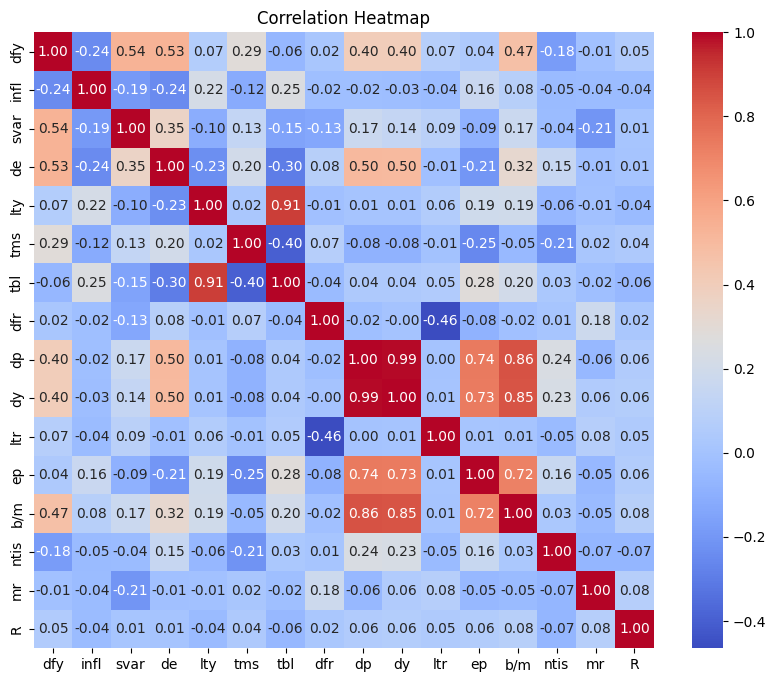

In [93]:
correlation_matrix=df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm")
plt.title('Correlation Heatmap')

#### Correlation analysis with R

Text(0.5, 1.0, 'Correlation Heatmap with R')

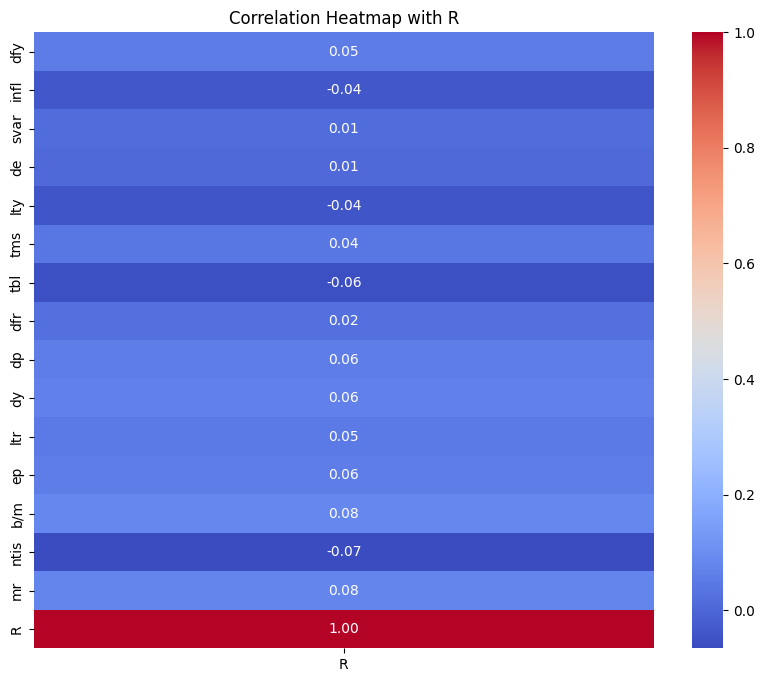

In [94]:
target_correlation = correlation_matrix[['R']]
plt.figure(figsize=(10,8))
sns.heatmap(target_correlation,annot=True,fmt=".2f",cmap="coolwarm")
plt.title('Correlation Heatmap with R')

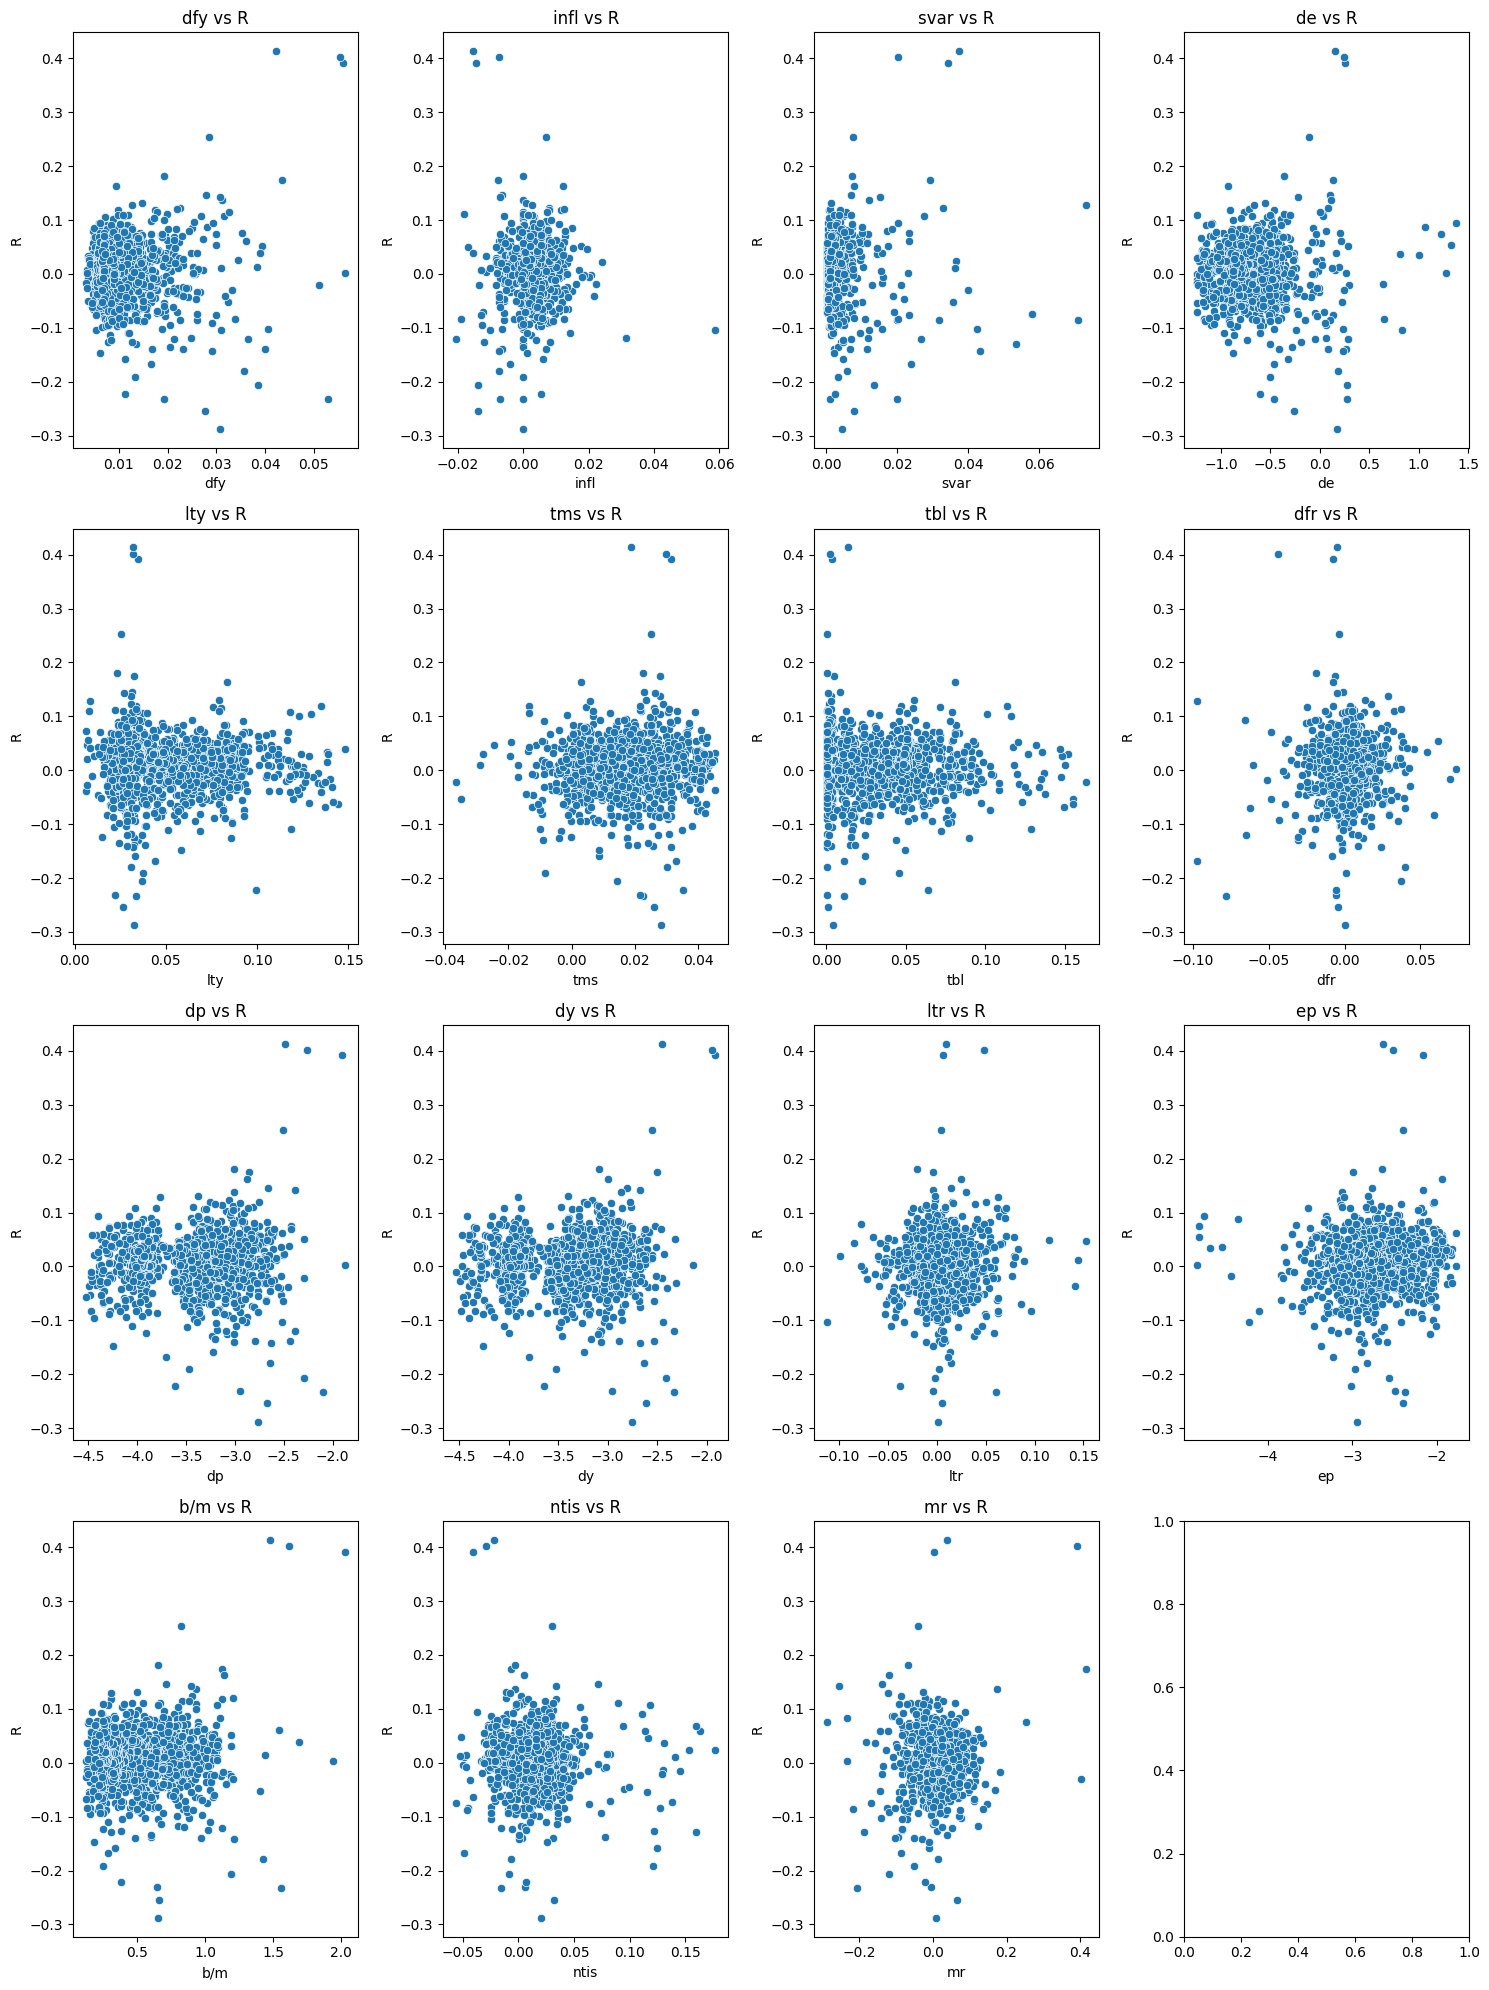

In [95]:
columns = [col for col in df.columns if col !='R']
n_cols=4
n_rows=-(-len(columns)//n_cols)
fig,axes=plt.subplots(n_rows,n_cols,figsize=(15,5*n_rows))
axes=axes.flatten()

for i, col in enumerate(columns):
  sns.scatterplot(ax=axes[i],x=df[col],y=df['R'])
  axes[i].set_title(f'{col} vs R')
  axes[i].set_xlabel(col)
  axes[i].set_ylabel('R')

plt.tight_layout()
plt.show()

### Residual plot


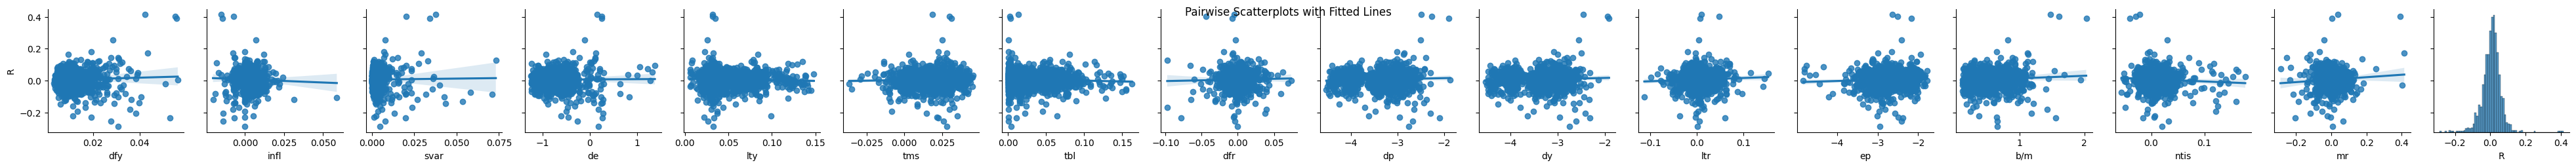

In [96]:
sns.pairplot(df,y_vars=['R'],x_vars=df.select_dtypes(include='number').columns,kind='reg')
plt.suptitle("Pairwise Scatterplots with Fitted Lines")
plt.show()

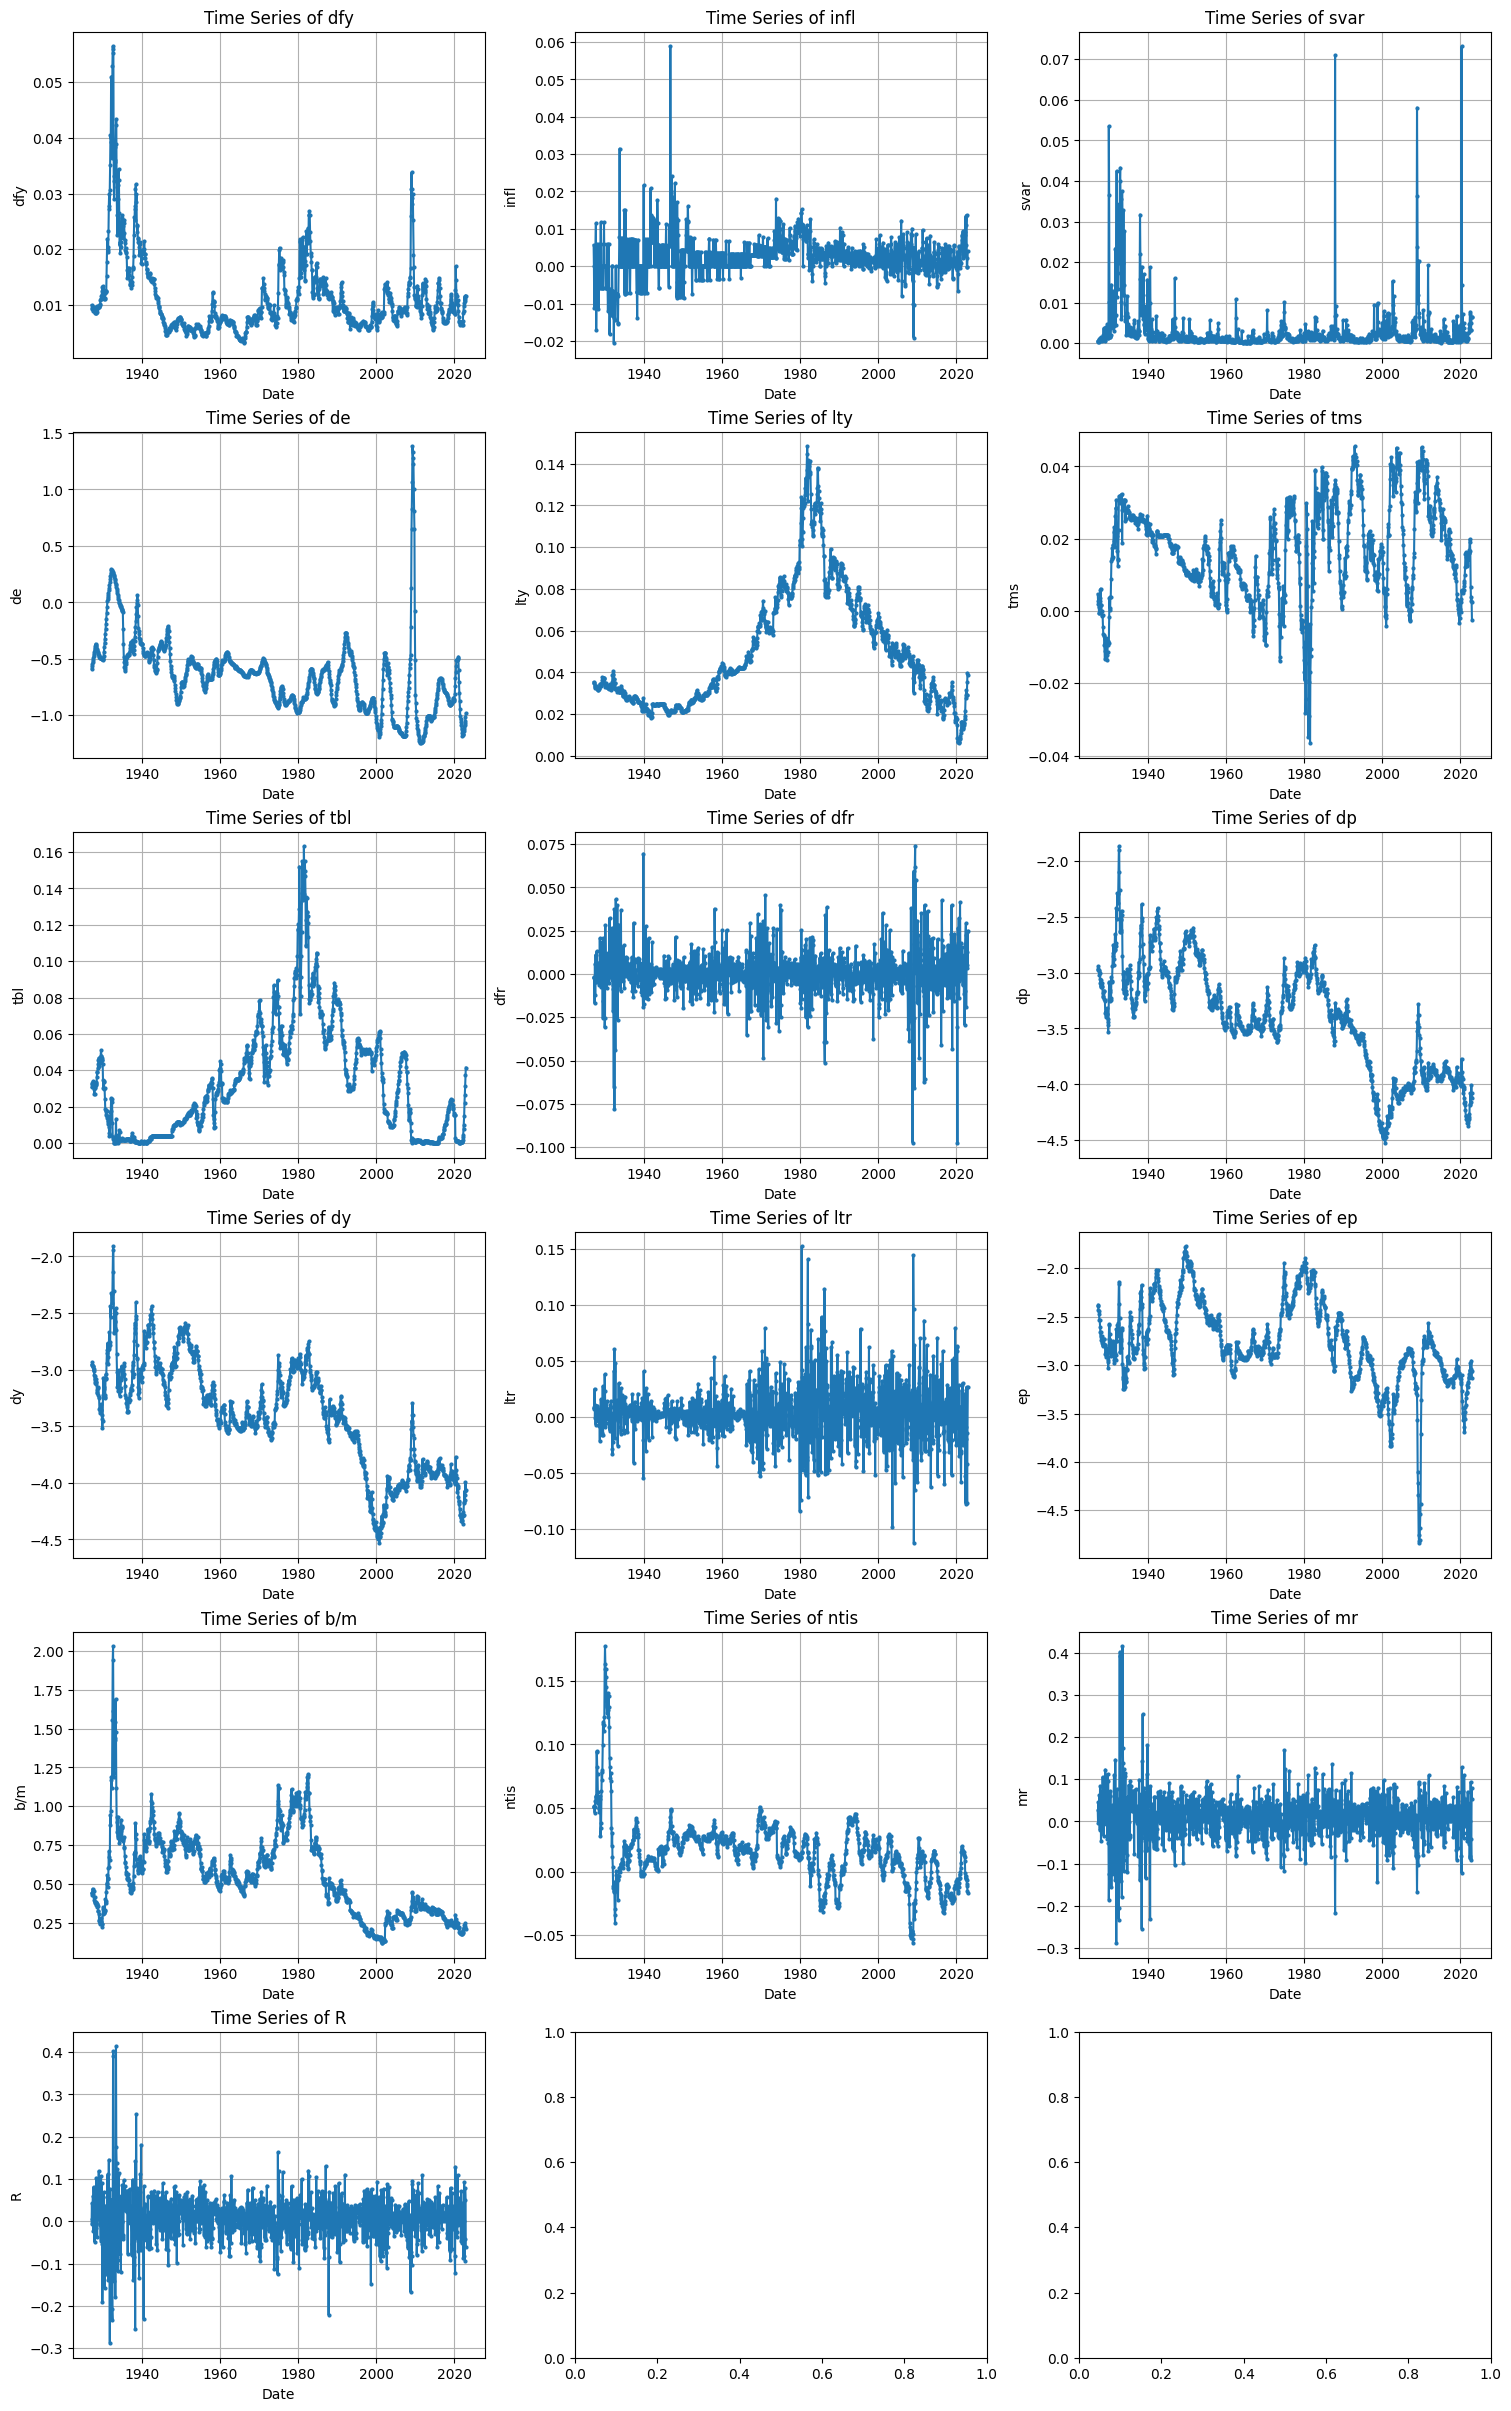

In [97]:
#Visualize Time series
columns = [col for col in df.columns if col !='R']
num_vars=len(df.columns)
rows=(num_vars//3)+(num_vars%3>0)
fig,axes=plt.subplots(rows,3,figsize=(15,rows*4),constrained_layout=True)

axes=axes.flatten()


for i, column in enumerate(df.columns):
  axes[i].plot(df.index,df[column],marker='o',linestyle='-',markersize=2)
  axes[i].set_title(f"Time Series of {column}")
  axes[i].set_xlabel("Date")
  axes[i].set_ylabel(column)
  axes[i].grid(True)

plt.show()



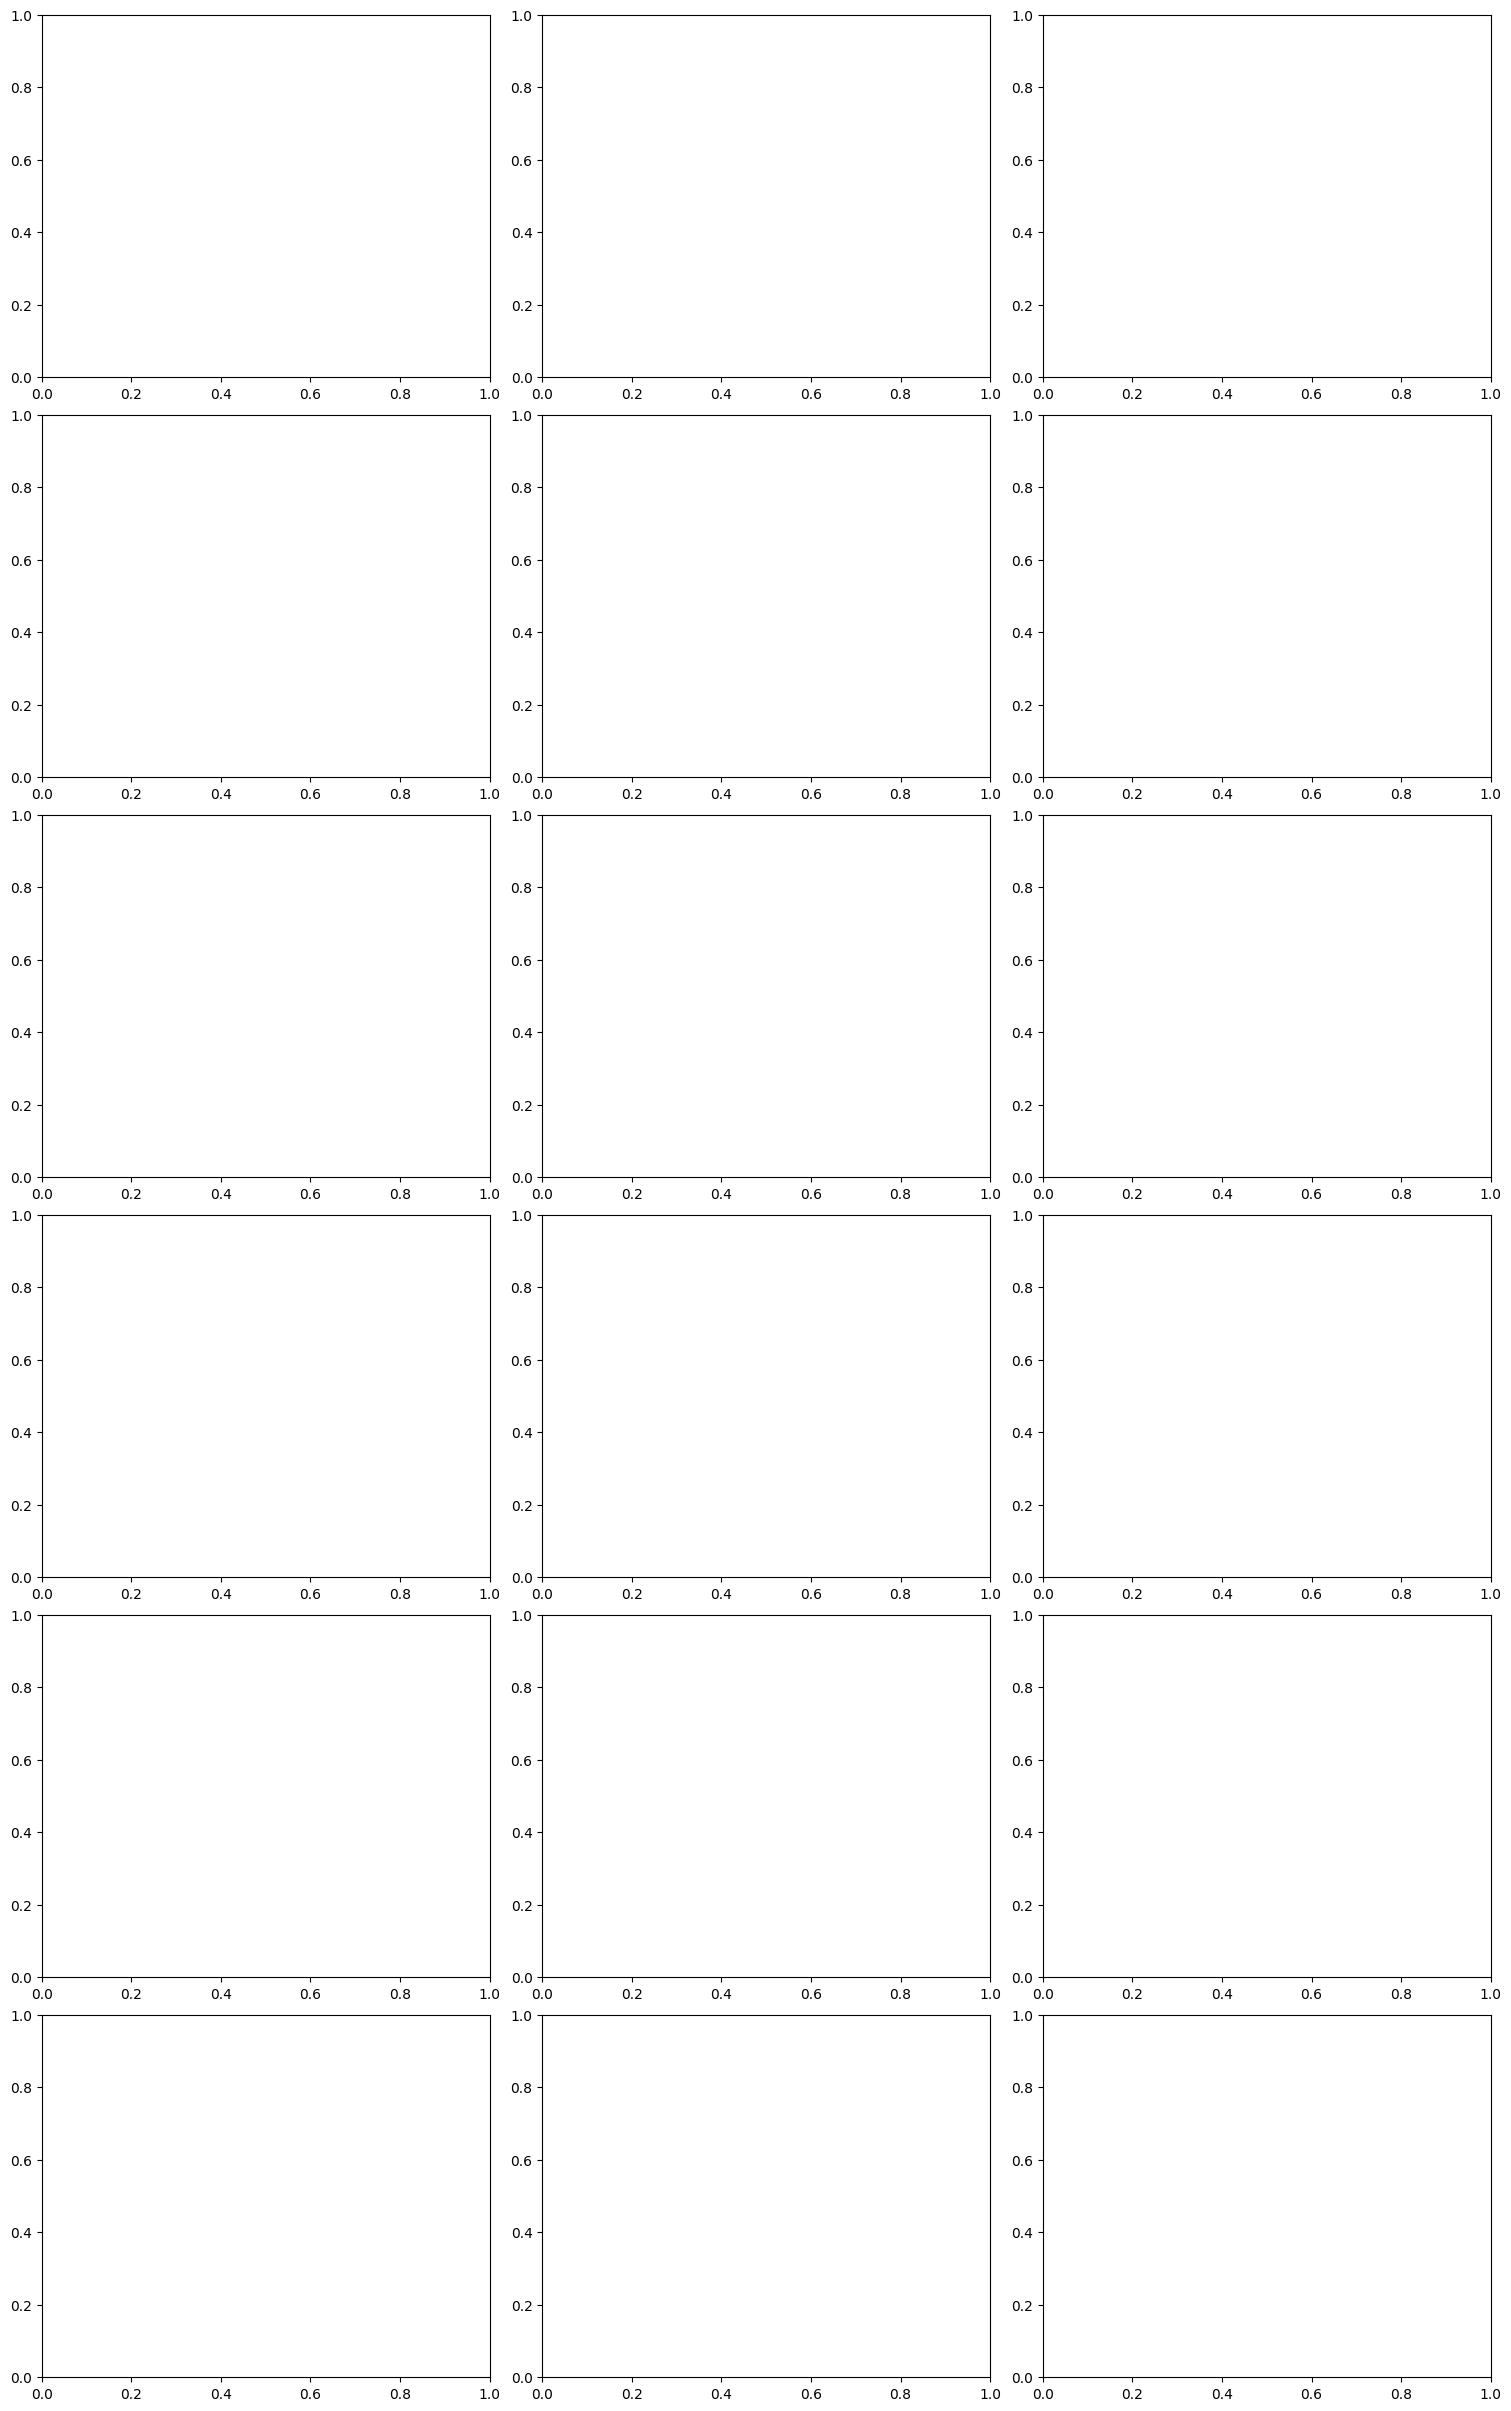

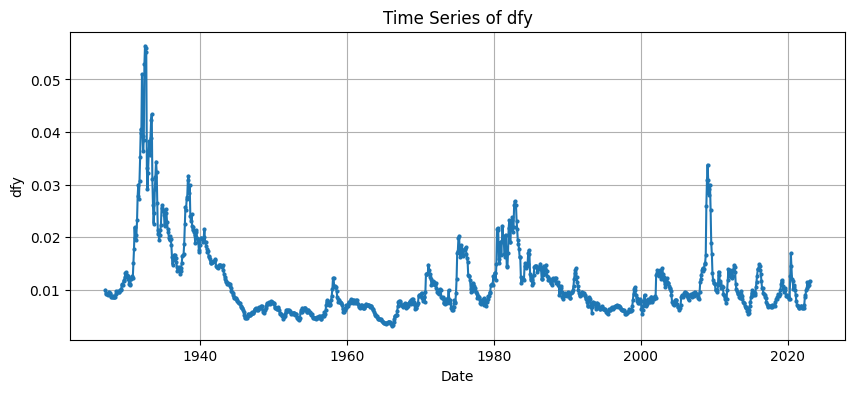

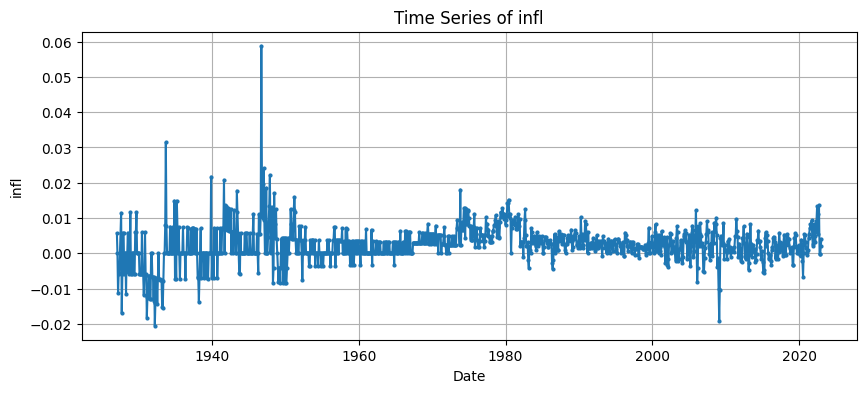

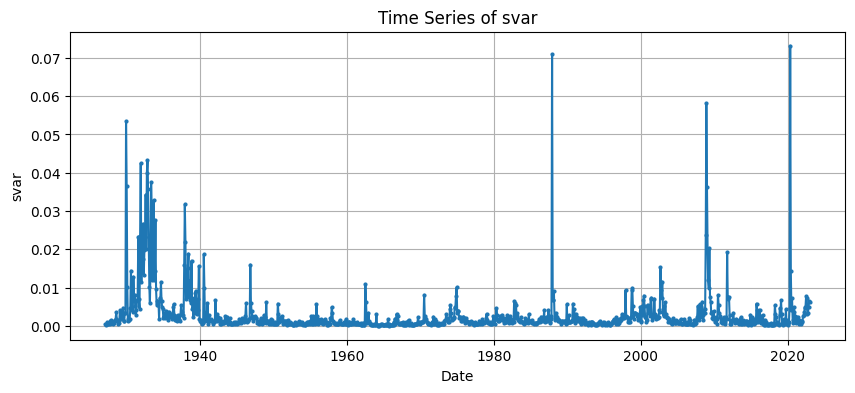

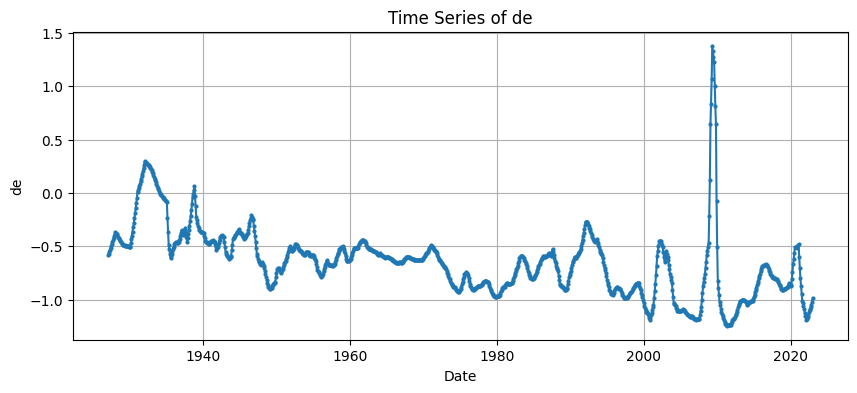

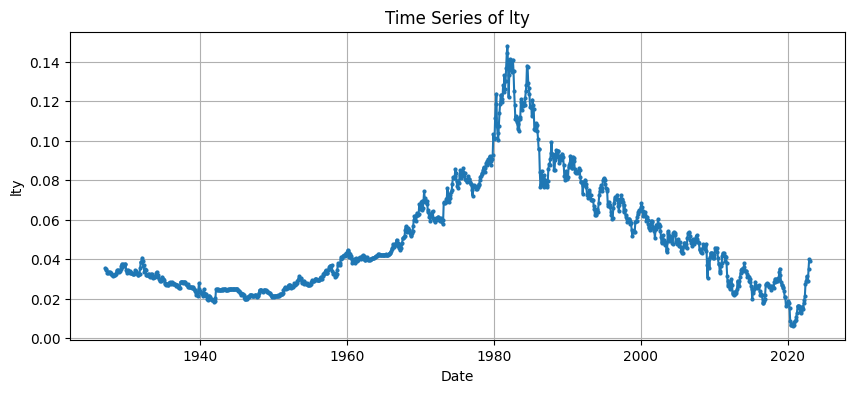

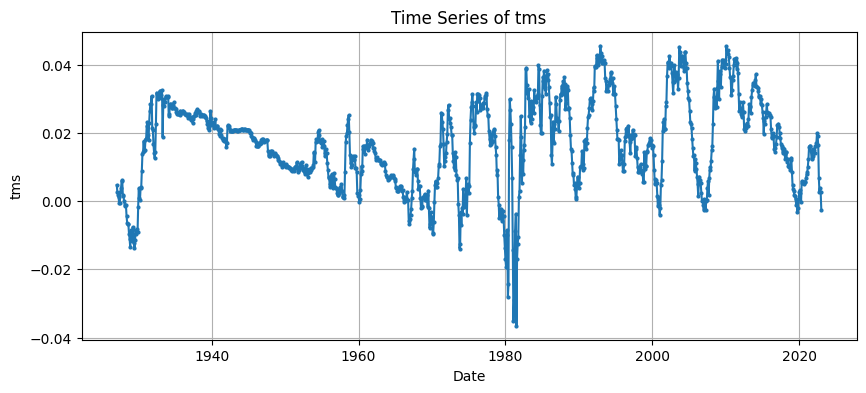

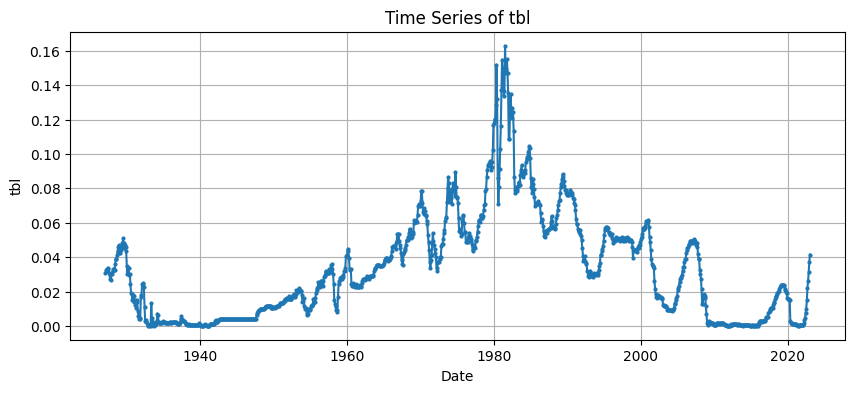

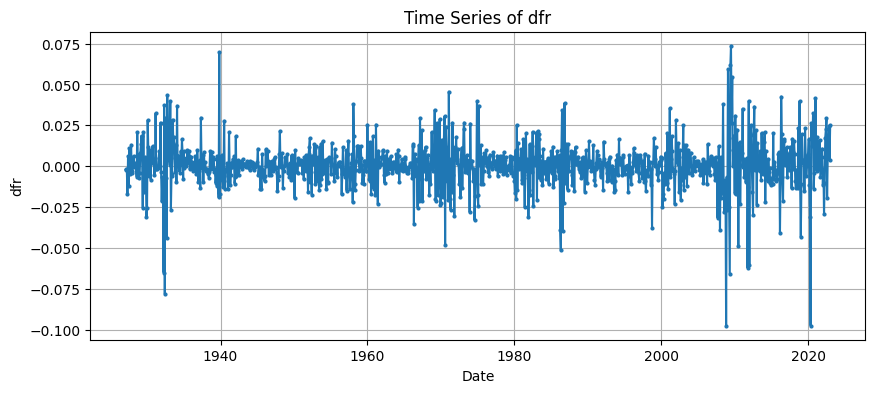

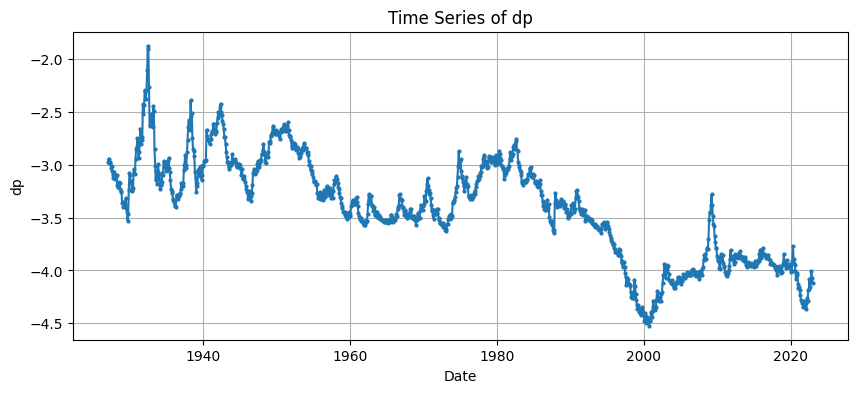

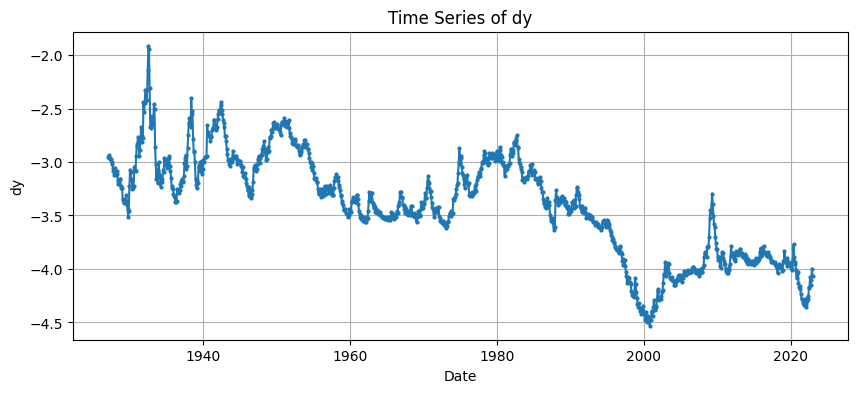

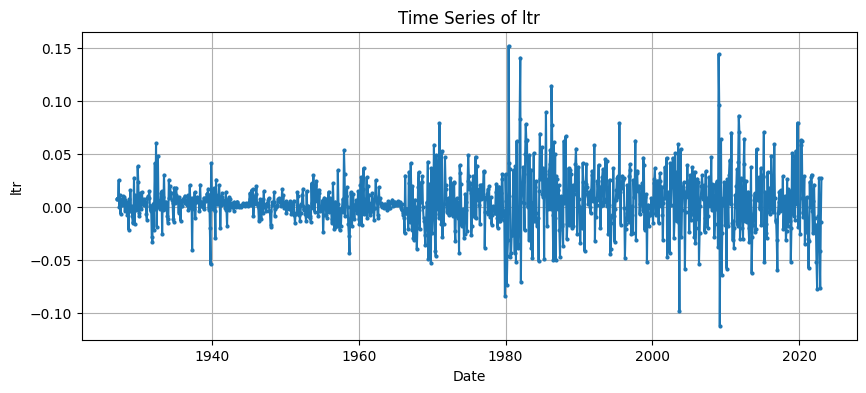

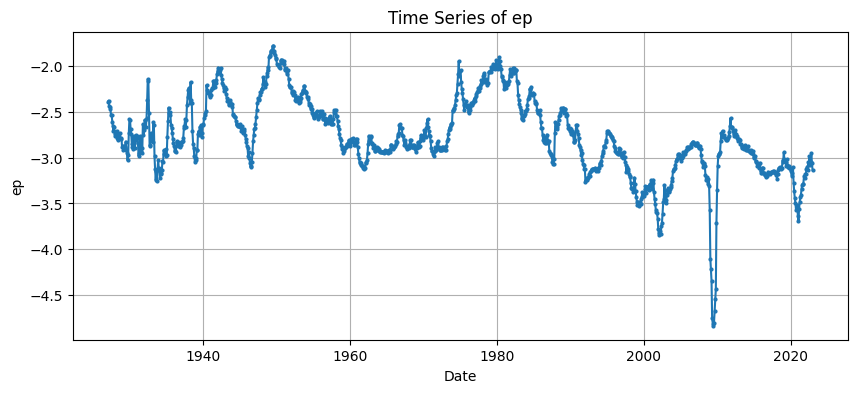

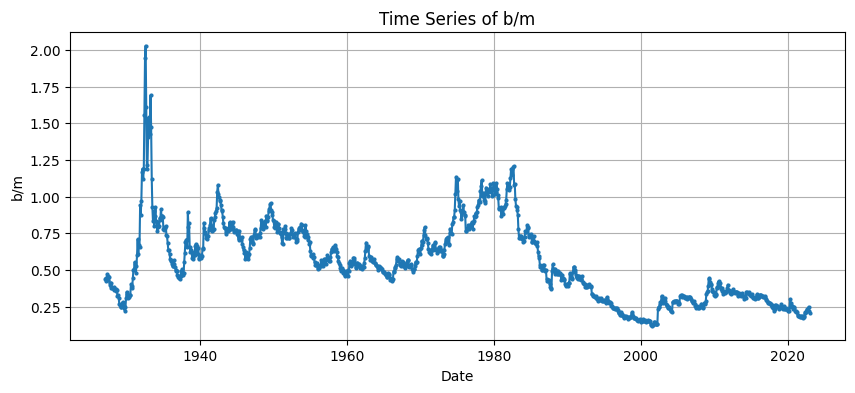

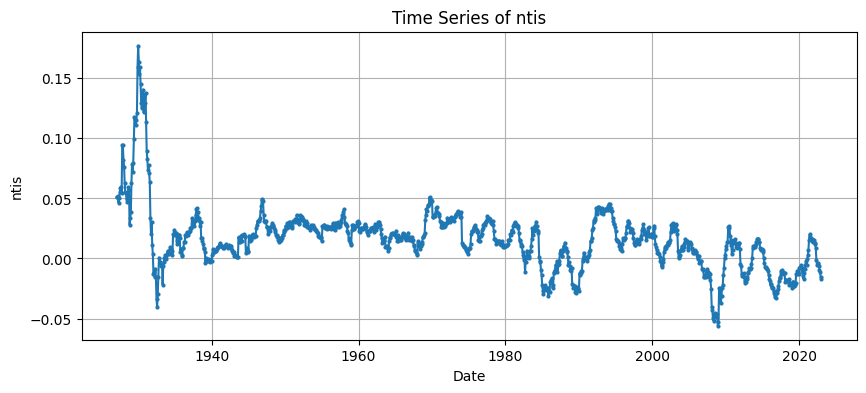

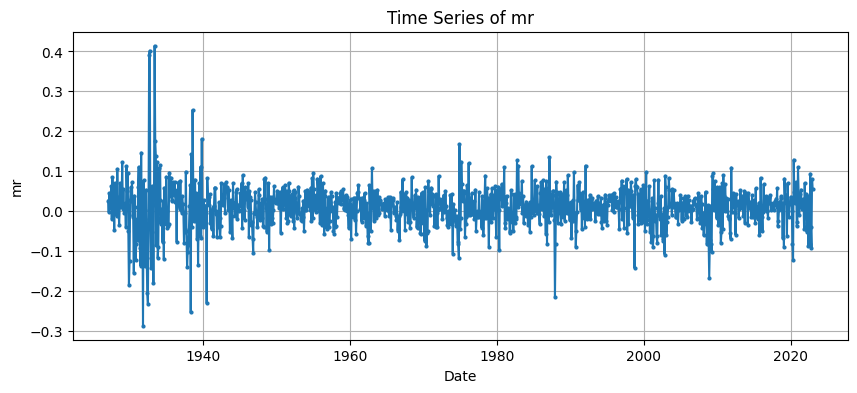

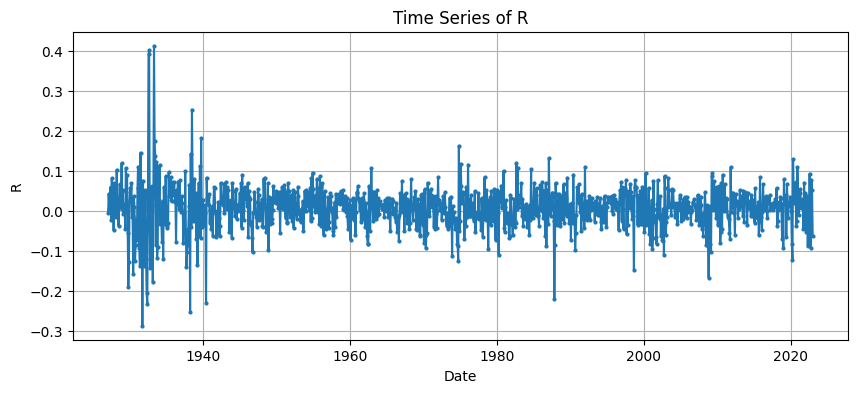

In [98]:
#Visualize Time series, this one bigger just for me to see better

num_vars=len(df.columns)
rows=(num_vars//3)+(num_vars%3>0)
fig,axes=plt.subplots(rows,3,figsize=(15,rows*4),constrained_layout=True)

for column in df.columns:
  plt.figure(figsize=(10,4))
  plt.plot(df.index,df[column],marker='o', linestyle='-',markersize=2)
  plt.title(f"Time Series of {column}")
  plt.xlabel("Date")
  plt.ylabel(column)
  plt.grid(True)
  plt.show()


#Feature Engineering


#Test with a few variable only


In [99]:
# Splitting data into training and testing sets based on a date threshold
split_date = '2019-01-01'
train_data = df[df.index < split_date]
test_data = df[df.index >= split_date]

# Separating features and target variable
x_train = train_data.drop('R', axis=1)
y_train = train_data['R']
x_test = test_data.drop('R', axis=1)
y_test = test_data['R']

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

# Feature engineering
x_train['svar_squared'] = x_train['svar'] ** 2
x_train['log_ep'] = np.log(x_train['ep'] + 1e-8)
x_train['infl_tbl'] = x_train['infl'] * x_train['tbl']
x_train['log_bm'] = np.log(x_train['b/m'] + 1e-8)
x_train['log_dy'] = np.log(x_train['dy'] + 1e-8)
x_train['ntis_squared'] = x_train['ntis'] ** 2
x_train['mr_squared'] = x_train['mr'] ** 2

x_test['svar_squared'] = x_test['svar'] ** 2
x_test['log_ep'] = np.log(x_test['ep'] + 1e-8)
x_test['infl_tbl'] = x_test['infl'] * x_test['tbl']
x_test['log_bm'] = np.log(x_test['b/m'] + 1e-8)
x_test['log_dy'] = np.log(x_test['dy'] + 1e-8)
x_test['ntis_squared'] = x_test['ntis'] ** 2
x_test['mr_squared'] = x_test['mr'] ** 2


/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/pandas/core/arra

In [100]:
# Check for NaN or Inf values in the training and test data
print(x_train.isna().sum())  # Check for missing values in x_train
print(x_train.isin([np.inf, -np.inf]).sum())  # Check for infinite values in x_train

print(x_test.isna().sum())  # Check for missing values in x_test
print(x_test.isin([np.inf, -np.inf]).sum())  # Check for infinite values in x_test


dfy               0
infl              0
svar              0
de                0
lty               0
tms               0
tbl               0
dfr               0
dp                0
dy                0
ltr               0
ep                0
b/m               0
ntis              0
mr                0
svar_squared      0
log_ep          615
infl_tbl          0
log_bm          595
log_dy          519
ntis_squared      0
mr_squared        0
dtype: int64
dfy             0
infl            0
svar            0
de              0
lty             0
tms             0
tbl             0
dfr             0
dp              0
dy              0
ltr             0
ep              0
b/m             0
ntis            0
mr              0
svar_squared    0
log_ep          0
infl_tbl        0
log_bm          0
log_dy          0
ntis_squared    0
mr_squared      0
dtype: int64
dfy              0
infl             0
svar             0
de               0
lty              0
tms              0
tbl              0
dfr  

In [101]:
#Model with only a few variables

selected_columns=['mr','ntis','b/m','ep','dy','tbl','infl','svar_squared','infl_tbl','log_bm','ntis_squared','mr_squared']
x_train_selected=x_train[selected_columns]
# Check and replace infinite values in x_train_selected
x_train_selected = x_train_selected.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN
x_train_selected = x_train_selected.fillna(x_train_selected.mean()) # Impute NaN with mean

# Apply scaling and add constant after handling inf values
x_train_selected=scaler.fit_transform(x_train_selected) 
x_train_selected=sm.add_constant(x_train_selected)

ols_model=sm.OLS(y_train,x_train_selected).fit()

y_train_pred=ols_model.predict(x_train_selected)
in_sample_r2 = ols_model.rsquared
print(f"In-Sample R^2: {in_sample_r2}")

x_test_selected=x_test[selected_columns]
# Check and replace infinite values in x_test_selected, and fill NaN with the mean of the training data
x_test_selected = x_test_selected.replace([np.inf, -np.inf], np.nan)  
x_test_selected = x_test_selected.fillna(x_train[selected_columns].mean()) # Use training data mean for imputation


# Apply scaling after handling inf values
x_test_selected=scaler.transform(x_test_selected) 
x_test_selected=sm.add_constant(x_test_selected)

y_test_pred=ols_model.predict(x_test_selected)

out_sample_r2 = r2_score(y_test, y_test_pred)
print(f"Out-of-Sample R^2: {out_sample_r2}")

In-Sample R^2: 0.04351377774427956
Out-of-Sample R^2: -0.28706497970691314


##TEST Crisis Model


In [102]:
#Model with Crisis
df.index=pd.to_datetime(df.index)

crisis_years=[1933,1939,1950,1987,1990,2008,2020]
df['Crisis']=df.index.year.isin(crisis_years).astype(int)

split_date='2019-01-01'
train_data=df[df.index <split_date]
x_train=train_data.drop('R',axis=1)
y_train=train_data[['R']]
test_data=df[df.index >=split_date]
x_test=test_data.drop('R',axis=1)
y_test=test_data[['R']]



scaler=StandardScaler()

x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)


x_train['Crisis']=train_data['Crisis']
x_test['Crisis']=test_data['Crisis']

x_train_const=sm.add_constant(x_train)
model=sm.OLS(y_train,x_train_const)
results=model.fit()

print('In sample results')
print(results.summary())


x_test_const = sm.add_constant(x_test)
y_test_pred = results.predict(x_test_const)

from sklearn.metrics import mean_squared_error, r2_score
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In sample results
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.324
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           2.99e-05
Time:                        20:33:31   Log-Likelihood:                 1671.5
No. Observations:                1104   AIC:                            -3313.
Df Residuals:                    1089   BIC:                            -3238.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.002  

In [103]:
x_test_const = sm.add_constant(x_test)
y_test_pred = results.predict(x_test_const)

from sklearn.metrics import mean_squared_error, r2_score
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"Out-of-Sample MSE: {mse_test:.4f}, R-squared: {r2_test:.4f}")

Out-of-Sample MSE: 0.0036, R-squared: -0.1487


In [104]:
x_train_no_crisis = x_train.drop('Crisis', axis=1)
x_test_no_crisis = x_test.drop('Crisis', axis=1)

x_train_const_no_crisis = sm.add_constant(x_train_no_crisis)
x_test_const_no_crisis = sm.add_constant(x_test_no_crisis)

model_no_crisis = sm.OLS(y_train, x_train_const_no_crisis)
results_no_crisis = model_no_crisis.fit()

print('In-sample results (without Crisis variable):')
print(results_no_crisis.summary())

y_pred_out_of_sample = results_no_crisis.predict(x_test_const_no_crisis)

# Compute and print out-of-sample R-squared
rss_out_of_sample = ((y_test.values.flatten() - y_pred_out_of_sample) ** 2).sum()  # Residual sum of squares
tss_out_of_sample = ((y_test.values.flatten() - y_test.values.flatten().mean()) ** 2).sum()  # Total sum of squares
r_squared_out_of_sample = 1 - rss_out_of_sample / tss_out_of_sample

print('\nOut-of-sample R-squared (without Crisis variable):', r_squared_out_of_sample)


In-sample results (without Crisis variable):
                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3.573
Date:                Sun, 05 Jan 2025   Prob (F-statistic):           1.59e-05
Time:                        20:33:32   Log-Likelihood:                 1671.4
No. Observations:                1104   AIC:                            -3315.
Df Residuals:                    1090   BIC:                            -3245.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

#Crisis Binary Variable


In [105]:
crisis_years=[1933,1939,1950,1987,1990,2008,2020]
df['crisis']=df.index.year.isin(crisis_years).astype(int)

print(df[['crisis']].head())

            crisis
date              
1927-01-31       0
1927-02-28       0
1927-03-31       0
1927-04-30       0
1927-05-31       0


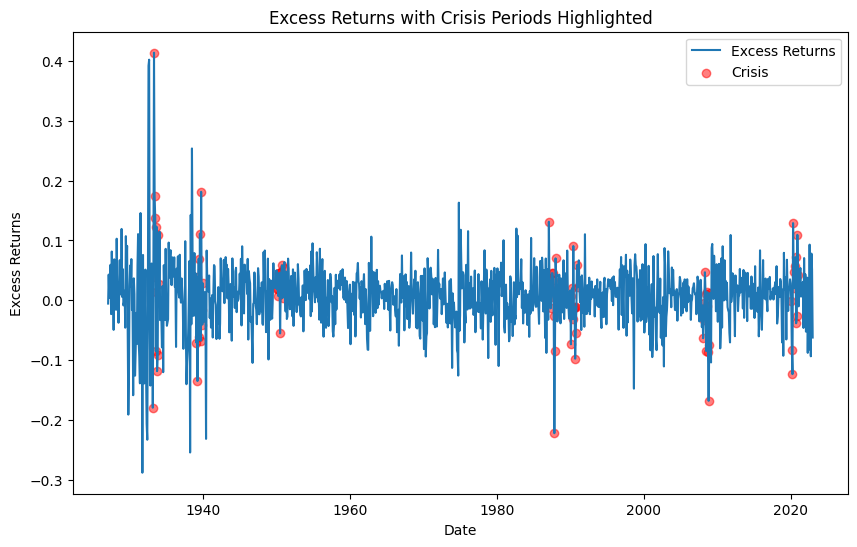

In [106]:
import matplotlib.pyplot as plt

# Plot excess returns with crisis periods highlighted
plt.figure(figsize=(10, 6))

# Plot excess returns
plt.plot(df.index, df['R'], label='Excess Returns')

# Highlight crisis periods
plt.scatter(df.index[df['crisis'] == 1], df['R'][df['crisis'] == 1], color='red', label='Crisis', alpha=0.5)

plt.title('Excess Returns with Crisis Periods Highlighted')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.legend()
plt.show()


### Box Plot
This is the analysis of the skewness of the data

<Axes: >

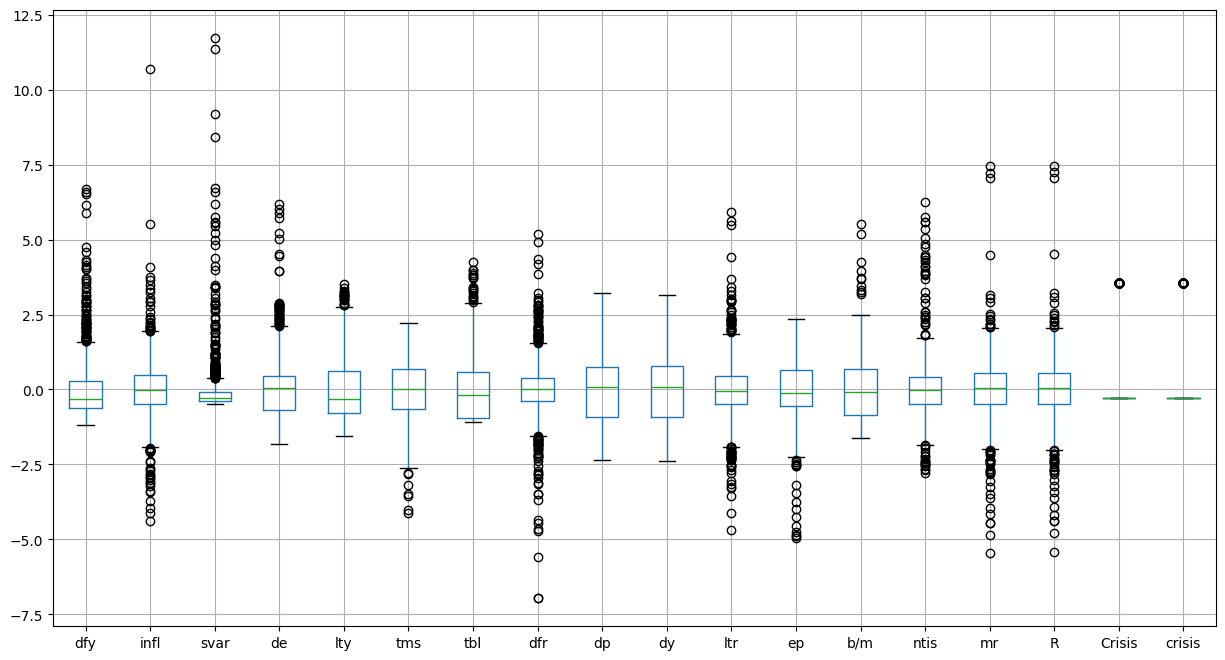

In [107]:
#This need to be done after the data are split
scaler=StandardScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)

scaled_df.boxplot(figsize=(15,8))

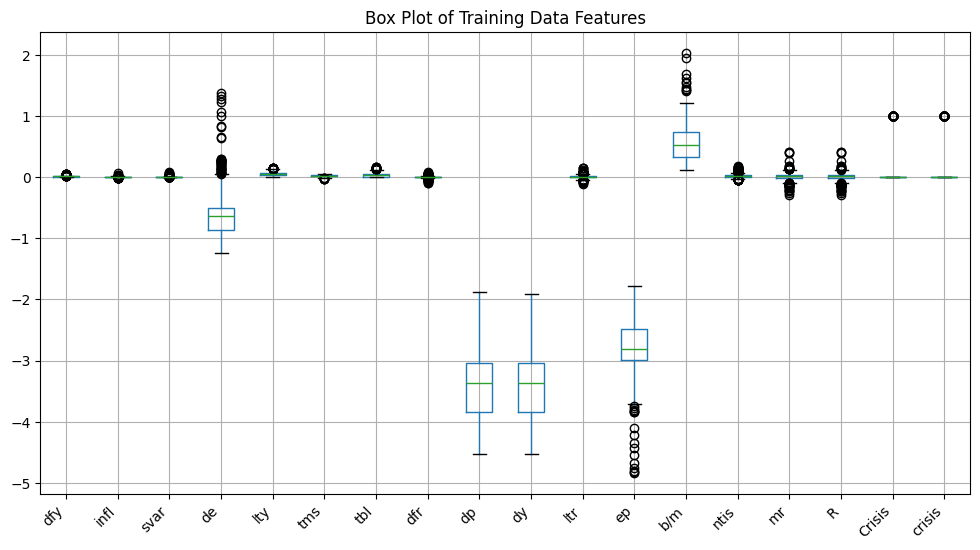

In [108]:
plt.figure(figsize=(12, 6))
df.boxplot()
plt.title('Box Plot of Training Data Features')
plt.xticks(rotation=45, ha='right')
plt.show()

### Autocorrelation and Partial Autocorrelation Analysis

#### 12 Month lag

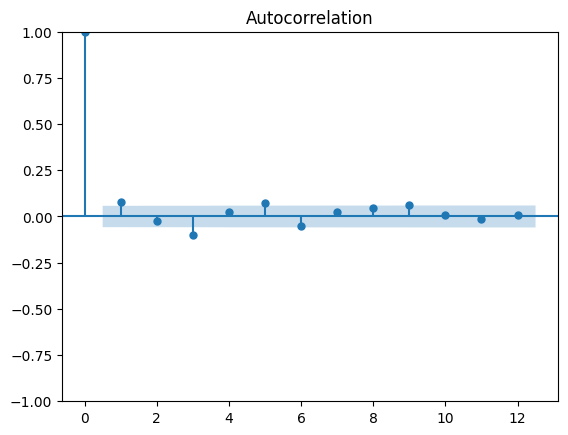

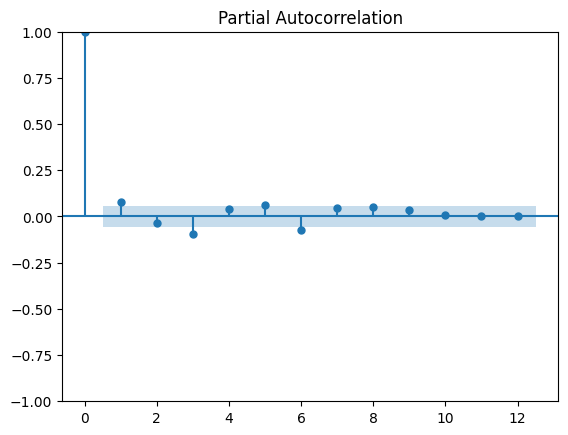

In [109]:
plot_acf(df['mr'],lags=12)
plot_pacf(df['mr'],lags=12)
plt.show()

#### 24 Month lag

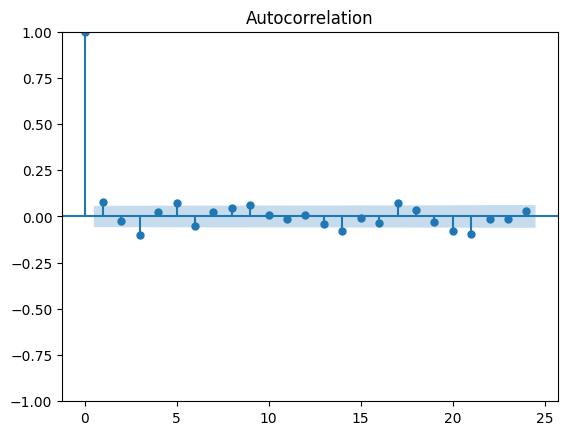

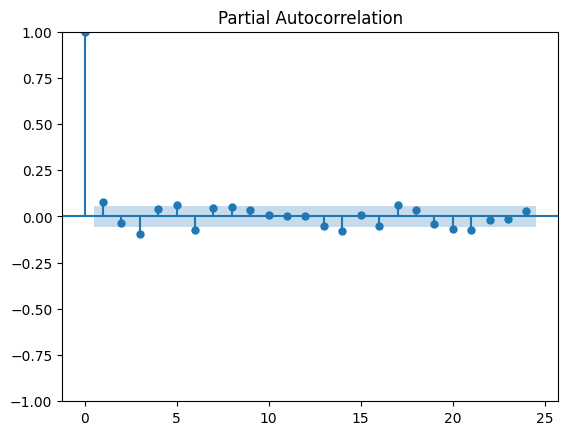

In [110]:
plot_acf(df['mr'],lags=24)
plot_pacf(df['mr'],lags=24)
plt.show()

# Pre-processing

## Feature Engineering

### Create a new feature for B/M and DP

In [111]:
df['dp_dy'] = (df['dp'] / df['dy'])
df = df.drop('dp', axis=1)
df = df.drop('dy', axis=1)

#### Analyse New Features 

### Moving Averages and Rolling Volitility 

#### Moving average for default yield spread

In [112]:
df['dfy_ma3'] = df['dfy'].rolling(window=3).mean()
df = df.drop('dfy', axis=1)



#### Moving average and rolling volatility for stock variance

In [113]:
df['svar_ma3'] = df['svar'].rolling(window=3).mean()
df['svar_vol3'] = df['svar'].rolling(window=3).std()
# df = df.drop('svar', axis=1)

#### Re-analyse data moving average and roling volitility 

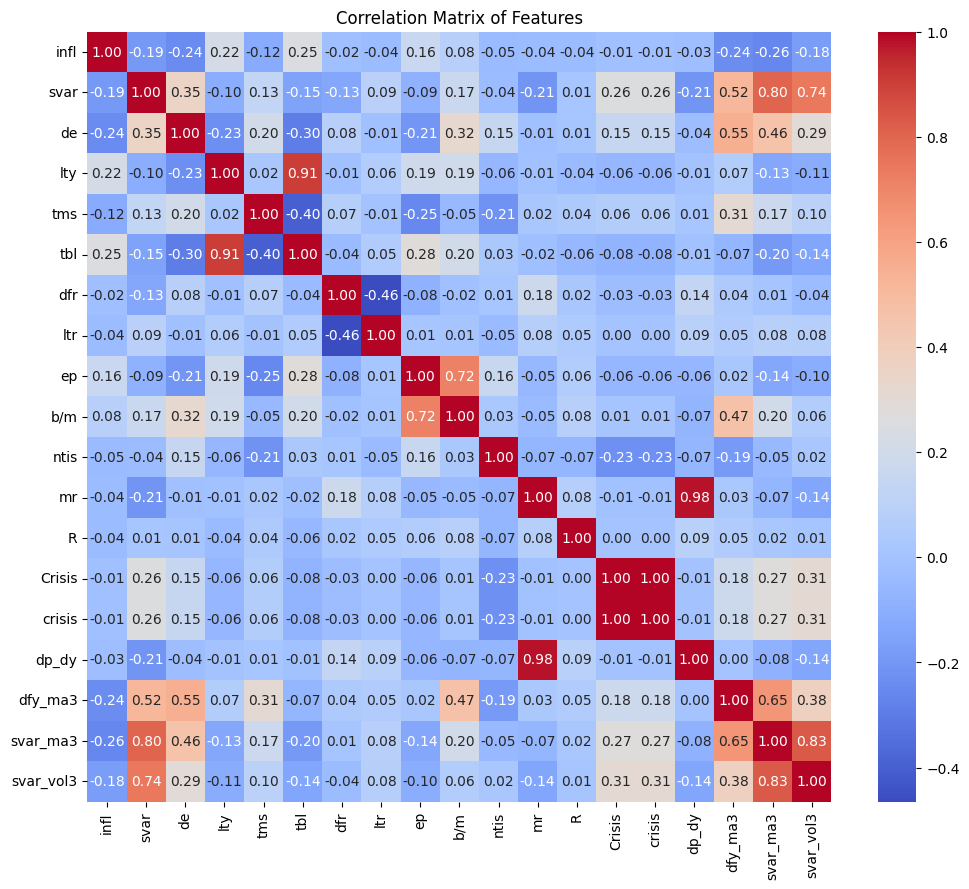

In [114]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

### Lagging 

#### Lag Market Returns 

In [115]:

lags_mr = list(range(1, 13,2)) + list(range(24, 60, 12))
# Apply lags for 'mr'
for lag in lags_mr:
    df[f'mr_lag{lag}'] = df['mr'].shift(lag)

# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')

assert not df.isnull().values.any(), "NaN values still exist!"

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_5785/934551410.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Lag Fundamental fators 

In [116]:
lags_tms_dfy = list(range(1, 6, 2) ) # Monthly lags up to 12 months
for lag in lags_tms_dfy:
    df[f'tms_lag{lag}'] = df['tms'].shift(lag)
    df[f'ntis_lag{lag}'] = df['ntis'].shift(lag)
    df[f'dfy_ma3_lag{lag}'] = df['dfy_ma3'].shift(lag)

# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')
assert not df.isnull().values.any(), "NaN values still exist!"

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_5785/1468953958.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Lag Economic Factors

In [117]:
lags_infl_ltr_bm = list(range(1, 6,2))  # Monthly lags for slower-moving variables
# Apply lags for 'infl', 'ltr', and 'b/m'
for lag in lags_infl_ltr_bm:
    df[f'infl_lag{lag}'] = df['infl'].shift(lag)
    df[f'ltr_lag{lag}'] = df['ltr'].shift(lag)
df[f'b/m{1}'] = df['b/m'].shift(1)
# Handle missing values
df = df.fillna(method='ffill').fillna(method='bfill')
assert not df.isnull().values.any(), "NaN values still exist!"

 

/var/folders/vw/trk5pzwn1qg69p8f6mv4gpf00000gn/T/ipykernel_5785/916812467.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


#### Analyse

### Dropping columns

#### Drop Book to market ratio

In [118]:
if 'b/m' in df.columns:
  df = df.drop('b/m', axis=1)
  print("Column 'b/m' removed successfully.")
else:
  print("Column 'b/m' not found in the DataFrame.")

Column 'b/m' removed successfully.


#### Drop long term yield 
Dropping LTY and TBL because the relationship is covered in term spread 

In [119]:
df = df.drop('lty', axis=1)

#### Analyse 

## Data Spliting

In [120]:
split_date='2019-01-01'
train_data=df[df.index <split_date]
x_train=train_data.drop('R',axis=1)
y_train=train_data[['R']]
test_data=df[df.index >=split_date]
x_test=test_data.drop('R',axis=1)
y_test=test_data[['R']]
x_train.shape

(1104, 41)

### Review Split 

## Data Transformation
The evaluation of the data revealed a high standard deviation in certain features. To mitigate the potential impact of this variability and ensure features contribute equally to model training, data standardization was applied. This process transforms the data to have zero mean and unit variance, effectively balancing the dataset.

### Data Scaling

In [121]:
scaler_x = StandardScaler()
columns = x_train.columns

x_train[columns] = scaler_x.fit_transform(x_train[columns])  # Fit on x_train, transform x_train
x_test[columns] = scaler_x.transform(x_test[columns])        # Transform x_test using the same scaler

### Analyse Transformation

In [122]:
x_train.describe()

,infl,svar,de,tms,tbl,dfr,ltr,ep,ntis,mr,...,tms_lag5,ntis_lag5,dfy_ma3_lag5,infl_lag1,ltr_lag1,infl_lag3,ltr_lag3,infl_lag5,ltr_lag5,b/m1
count,1104.000000,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1104.000000,1.104000e+03,1.104000e+03,1104.000000,1.104000e+03,...,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1.104000e+03,1104.000000,1104.000000,1.104000e+03
mean,0.000000,-7.723291e-17,-1.029772e-16,2.574430e-16,-1.029772e-16,0.000000,-1.287215e-17,-6.178632e-16,0.000000,1.448117e-17,...,2.059544e-16,5.148860e-17,1.609019e-16,-1.287215e-17,1.930823e-17,-1.287215e-17,-1.287215e-17,0.000000,0.000000,-2.059544e-16
std,1.000453,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453,1.000453e+00,1.000453e+00,1.000453,1.000453e+00,...,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453e+00,1.000453,1.000453,1.000453e+00
min,-4.334089,-4.854632e-01,-1.849301e+00,-4.130574e+00,-1.095474e+00,-7.154197,-4.795727e+00,-5.033374e+00,-2.824147,-5.478076e+00,...,-4.122536e+00,-2.839755e+00,-1.159668e+00,-4.334052e+00,-4.801779e+00,-4.334593e+00,-4.819021e+00,-4.335236,-4.821035,-1.685676e+00
25%,-0.458492,-3.775397e-01,-6.712214e-01,-6.411073e-01,-9.528309e-01,-0.397168,-4.785229e-01,-5.034165e-01,-0.436538,-4.827944e-01,...,-6.458269e-01,-4.439770e-01,-6.264143e-01,-4.590860e-01,-4.776984e-01,-4.606161e-01,-4.792745e-01,-0.462165,-0.478899,-8.602058e-01
50%,-0.002723,-2.790525e-01,2.515773e-02,3.675819e-02,-1.456002e-01,0.012348,-6.482500e-02,-1.235244e-01,0.000969,6.158086e-02,...,3.874622e-02,-9.270953e-03,-3.182035e-01,-2.839715e-03,-6.334148e-02,-2.949829e-03,-6.362571e-02,-0.001732,-0.063206,-1.007907e-01
75%,0.494096,-7.143651e-02,4.253461e-01,6.915147e-01,5.684261e-01,0.392614,4.604895e-01,6.507735e-01,0.406949,5.398550e-01,...,6.925521e-01,3.999060e-01,2.896566e-01,4.945554e-01,4.587071e-01,5.006097e-01,4.567695e-01,0.502964,0.456409,6.818500e-01
max,10.636355,1.190379e+01,6.149646e+00,2.185900e+00,4.185565e+00,5.365319,6.046436e+00,2.321679e+00,6.213600,7.472241e+00,...,2.184768e+00,6.207468e+00,6.550494e+00,1.063395e+01,6.057653e+00,1.062959e+01,6.072005e+00,10.625450,6.073405,5.523868e+00


# Models

## Linear Regression

### OLS

#### Training

In [123]:
ols = LinearRegression()
ols = ols.fit(x_train, y_train)
y_insample_pred_ols = ols.predict(x_train)
y_outsample_pred_ols = ols.predict(x_test)

#### Analysing OLS Coeeficient 

In [124]:
# Assuming 'ols' is the fitted Linear Regression model from your code
# Access coefficients
coefficients = ols.coef_

# Access feature names
feature_names = x_train.columns

# Create a DataFrame for coefficients and their importance
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

# Sort by absolute value of coefficients (importance)
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)
coefficients_df = coefficients_df.drop(columns=['Abs_Coefficient'])

# Display the coefficients and their importance
coefficients_df

,Feature,Coefficient
30,dfy_ma3_lag3,-0.054950
27,dfy_ma3_lag1,0.037840
12,dp_dy,0.024956
32,ntis_lag5,-0.023496
9,mr,-0.022969
33,dfy_ma3_lag5,0.018553
29,ntis_lag3,0.017460
26,ntis_lag1,0.011524
8,ntis,-0.010271
40,b/m1,0.008963


### Ridge

#### Time serires Cross validation

In [125]:
tscv = TimeSeriesSplit(n_splits=4, test_size=12 )

####  Alpha Cross Validation

In [126]:
alphas = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=tscv, scoring='neg_mean_squared_error')
ridge_cv.fit(x_train, y_train)

RidgeCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=12),
        scoring='neg_mean_squared_error')

#### Training

In [127]:
ridge = Ridge(alpha=ridge_cv.alpha_,max_iter=1000,fit_intercept=False)
ridge.fit(x_train, y_train)
y_insample_pred_ridge = ridge.predict(x_train)
y_outsample_pred_ridge = ridge.predict(x_test)

### Lasso

#### Time serires Cross validation

In [128]:
tscv = TimeSeriesSplit(n_splits=4, test_size=12 )

#### Alpha Cross Validation

In [129]:
alphas = np.logspace(-4, 4, 100) 
lasso_cv = LassoCV(alphas=alphas, cv=tscv)
lasso_cv.fit(x_train, y_train)

/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:1659: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-0...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=12))

#### Analysing the coefficent

In [130]:
# @ Analysing the coefficent
coefficients = lasso_cv.coef_

feature_names = x_train.columns
dropped_features = feature_names[np.where(coefficients ==0)]
print(dropped_features)
import numpy as np

importance = np.abs(coefficients)
sorted_indices = np.argsort(importance)[::-1]  # Indices sorted by importance

# If you have feature names (e.g., from a pandas DataFrame):
for i in sorted_indices:
    print(f"{feature_names[i]}: {importance[i]}")

Index(['mr_lag48', 'tms_lag1', 'tms_lag3', 'tms_lag5'], dtype='object')
dfy_ma3_lag3: 0.03706864871314241
ntis_lag5: 0.020089976084480175
dp_dy: 0.019988994887559793
mr: 0.01747794843408359
dfy_ma3_lag1: 0.01500949730851414
ntis_lag3: 0.01393820300348457
dfy_ma3_lag5: 0.010433533858184551
b/m1: 0.009521574759098587
dfy_ma3: 0.009085024865907237
ntis_lag1: 0.005019244875441616
dfr: 0.004597531881959469
mr_lag3: 0.004423831087641657
mr_lag5: 0.004327164760197927
ltr: 0.004326976749385792
infl_lag3: 0.0038477252416766867
tbl: 0.003651422478302571
infl_lag5: 0.003490580311016969
ntis: 0.0032682996926313404
de: 0.003177979184912254
ltr_lag5: 0.00290698572299954
mr_lag24: 0.0024025715260354934
mr_lag7: 0.0023589363782602663
svar_vol3: 0.0018151798924523218
mr_lag36: 0.001606529434650331
Crisis: 0.0013836033213564156
tms: 0.001215036159563063
mr_lag1: 0.000882611283710185
infl: 0.0008561872009586264
ltr_lag3: 0.0008391500311613684
svar_ma3: 0.0007392758225599184
mr_lag9: 0.0006633910705653494

#### Training

In [131]:
lasso = Lasso(alpha=lasso_cv.alpha_,max_iter=1000,fit_intercept=False)
lasso.fit(x_train, y_train)
y_insample_pred_lasso = lasso.predict(x_train)
y_outsample_pred_lasso = lasso.predict(x_test)

## Random Forest

In [132]:
# print('MSE test set', round (mse_test, 2))
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Implement Random Forest with extensive hyperparameter tuning
rf = RandomForestRegressor(random_state=42)

rf_params = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 15],
}
rf_random = RandomizedSearchCV(
    rf, rf_params, cv=TimeSeriesSplit(n_splits=4, test_size=12), scoring="neg_mean_squared_error"
)

rf_random.fit(x_train, y_train)
print("Best Random Forest Params:", rf_random.best_params_)

# Predict and evaluate Random Forest - In-sample and Out-of-sample
y_train_pred_rf = rf_random.predict(x_train)  # In-sample predictions
y_test_pred_rf = rf_random.predict(x_test)    # Out-of-sample predictions

# In-sample evaluation
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Random Forest - Training MSE: {mse_train_rf:.4f}, Training R²: {r2_train_rf:.4f}")

# Out-of-sample evaluation
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
print(f"Random Forest - Testing MSE: {mse_test_rf:.4f}, Testing R²: {r2_test_rf:.4f}")

/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/Qmul/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

Best Random Forest Params: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': None}
Random Forest - Training MSE: 0.0005, Training R²: 0.8247
Random Forest - Testing MSE: 0.0037, Testing R²: -0.1924


# Performance Test

## Performance Metrics

### Linear Regression 

#### In-sample Performance Comparism

In [133]:
mse_insample_ols = mean_squared_error(y_train, y_insample_pred_ols)
r2_insample_ols = r2_score(y_train, y_insample_pred_ols)
mse_insample_ridge = mean_squared_error(y_train, y_insample_pred_ridge)
r2_insample_ridge = r2_score(y_train, y_insample_pred_ridge)
mse_insample_lasso = mean_squared_error(y_train, y_insample_pred_lasso)
r2_insample_lasso = r2_score(y_train, y_insample_pred_lasso)
print('Model Insample Performance Comparison:')
print(f'OLS MSE: {mse_insample_ols:.4f}, R-squared: {r2_insample_ols:.4f}')
print(f'Ridge MSE: {mse_insample_ridge:.4f}, R-squared: {r2_insample_ridge:.4f}')
print(f'Lasso MSE: {mse_insample_lasso:.4f}, R-squared: {r2_insample_lasso:.4f}')


Model Insample Performance Comparison:
OLS MSE: 0.0027, R-squared: 0.0969
Ridge MSE: 0.0027, R-squared: 0.0824
Lasso MSE: 0.0027, R-squared: 0.0797


#### out-sample Performance Comparism

In [134]:
mse_outsample_ols = mean_squared_error(y_test, y_outsample_pred_ols)
r2_outsample_ols = r2_score(y_test, y_outsample_pred_ols)
mse_outsample_ridge = mean_squared_error(y_test, y_outsample_pred_ridge)
r2_outsample_ridge = r2_score(y_test, y_outsample_pred_ridge)
mse_outsample_lasso = mean_squared_error(y_test, y_outsample_pred_lasso)
r2_outsample_lasso = r2_score(y_test, y_outsample_pred_lasso)
print('Model Outsample Performance Comparison:')
print(f'OLS MSE: {mse_outsample_ols:.4f}, R-squared: {r2_outsample_ols:.4f}')
print(f'Ridge MSE: {mse_outsample_ridge:.4f}, R-squared: {r2_outsample_ridge:.4f}')
print(f'Lasso MSE: {mse_outsample_lasso:.4f}, R-squared: {r2_outsample_lasso:.4f}')

Model Outsample Performance Comparison:
OLS MSE: 0.0033, R-squared: -0.0701
Ridge MSE: 0.0035, R-squared: -0.1377
Lasso MSE: 0.0035, R-squared: -0.1270


## Visuals

### Plot for Linear Regression   


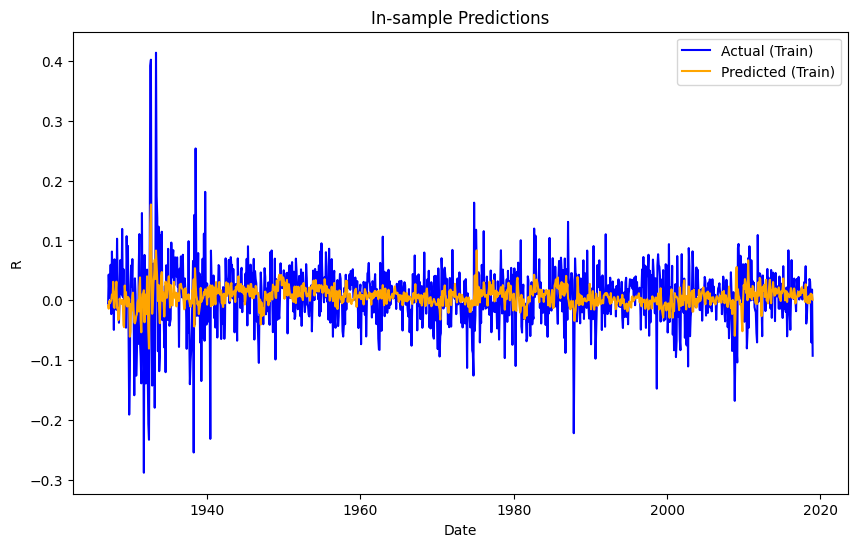

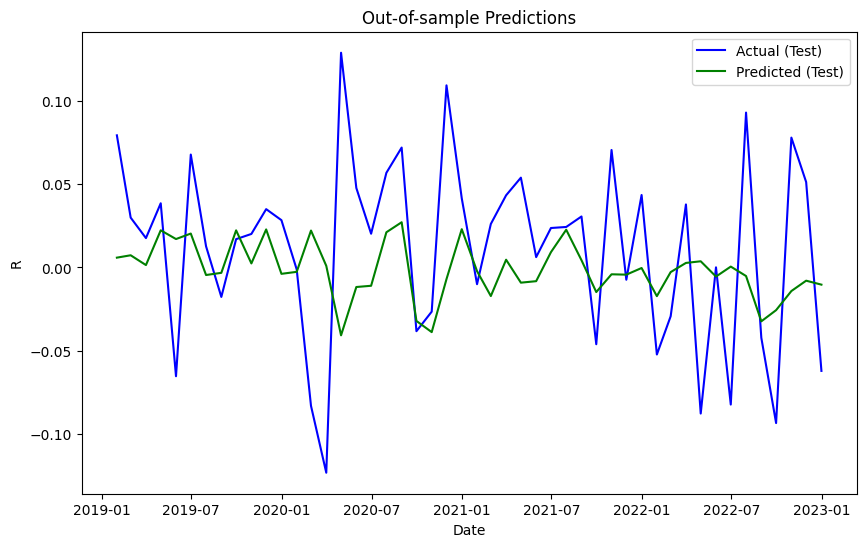

In [135]:
# In-sample Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label="Actual (Train)", color="blue")
plt.plot(y_train.index, y_insample_pred_ols, label="Predicted (Train)", color="orange")
plt.title("In-sample Predictions")
plt.xlabel("Date")
plt.ylabel("R")
plt.legend()
plt.show()

# Out-of-sample Predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual (Test)", color="blue")
plt.plot(y_test.index, y_outsample_pred_ols, label="Predicted (Test)", color="green")
plt.title("Out-of-sample Predictions")
plt.xlabel("Date")
plt.ylabel("R")
plt.legend()
plt.show()


### Plot for Random Forest


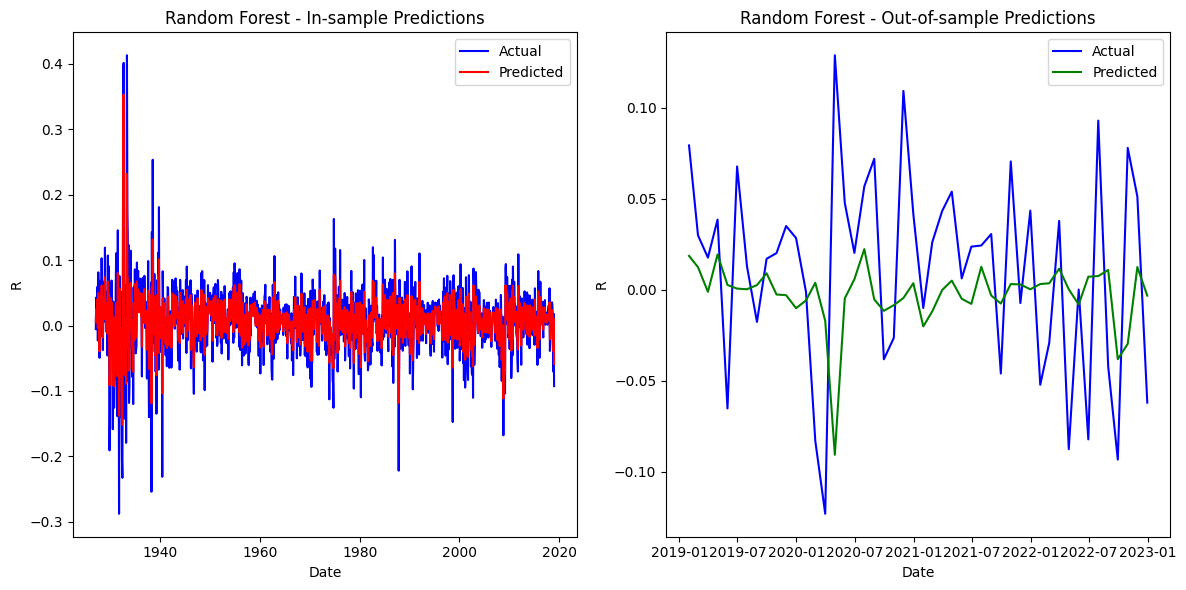

In [136]:
plt.figure(figsize=(12, 6))

# In-sample plot
plt.subplot(1, 2, 1)
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, y_train_pred_rf, label='Predicted', color='red')
plt.title('Random Forest - In-sample Predictions')
plt.xlabel('Date')
plt.ylabel('R')
plt.legend()

# Out-of-sample plot
plt.subplot(1, 2, 2)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_test_pred_rf, label='Predicted', color='green')
plt.title('Random Forest - Out-of-sample Predictions')
plt.xlabel('Date')
plt.ylabel('R')
plt.legend()

plt.tight_layout()
plt.show()

# Financial Analysis

## Analysing data of Know Historical events

## Market Valuation Signal

### Dividend to Price Ratio vs. Book to Market Ratio
The Graph shows strong correlation between the book to market ratio and Divends to price ratio

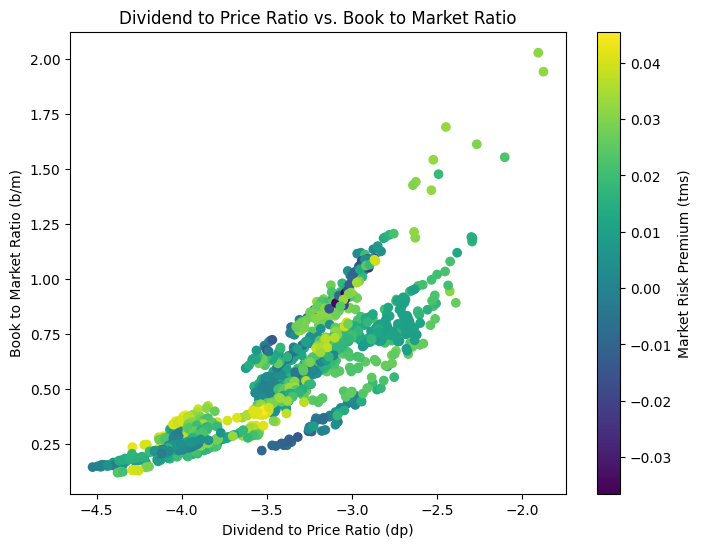

In [139]:
plt.figure(figsize=(8, 6))
plt.scatter(DF_FINAL['dp'], DF_FINAL['b/m'], c=DF_FINAL['tms'], cmap='viridis')
plt.xlabel('Dividend to Price Ratio (dp)')
plt.ylabel('Book to Market Ratio (b/m)')
plt.title('Dividend to Price Ratio vs. Book to Market Ratio')
_ = plt.colorbar(label='Market Risk Premium (tms)')

### Dividend price vs Dividend Yield
Dividend price vs Dividend Yield

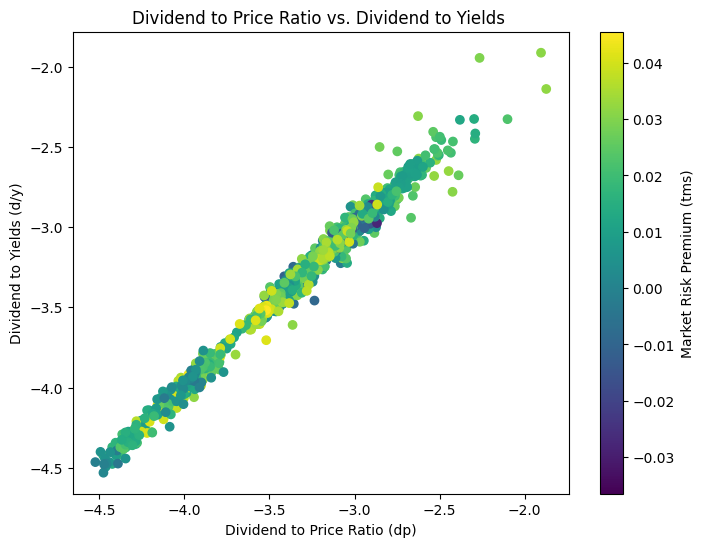

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(DF_FINAL['dp'], DF_FINAL['dy'], c=df['tms'], cmap='viridis')
plt.xlabel('Dividend to Price Ratio (dp)')
plt.ylabel('Dividend to Yields (d/y)')
plt.title('Dividend to Price Ratio vs. Dividend to Yields ')
_ = plt.colorbar(label='Market Risk Premium (tms)')

##  Spike Analysis 

[(Timestamp('1930-06-30 00:00:00'), Timestamp('1930-06-30 00:00:00')), (Timestamp('1930-07-31 00:00:00'), Timestamp('1930-07-31 00:00:00')), (Timestamp('1931-06-30 00:00:00'), Timestamp('1931-06-30 00:00:00')), (Timestamp('1931-09-30 00:00:00'), Timestamp('1931-09-30 00:00:00')), (Timestamp('1931-10-31 00:00:00'), Timestamp('1931-11-30 00:00:00')), (Timestamp('1931-12-31 00:00:00'), Timestamp('1932-02-29 00:00:00')), (Timestamp('1932-03-31 00:00:00'), Timestamp('1932-04-30 00:00:00')), (Timestamp('1932-05-31 00:00:00'), Timestamp('1932-06-30 00:00:00')), (Timestamp('1932-07-31 00:00:00'), Timestamp('1932-09-30 00:00:00')), (Timestamp('1932-10-31 00:00:00'), Timestamp('1932-11-30 00:00:00')), (Timestamp('1932-12-31 00:00:00'), Timestamp('1933-02-28 00:00:00')), (Timestamp('1933-03-31 00:00:00'), Timestamp('1933-04-30 00:00:00')), (Timestamp('1933-05-31 00:00:00'), Timestamp('1933-06-30 00:00:00')), (Timestamp('1933-07-31 00:00:00'), Timestamp('1933-09-30 00:00:00')), (Timestamp('1933-10

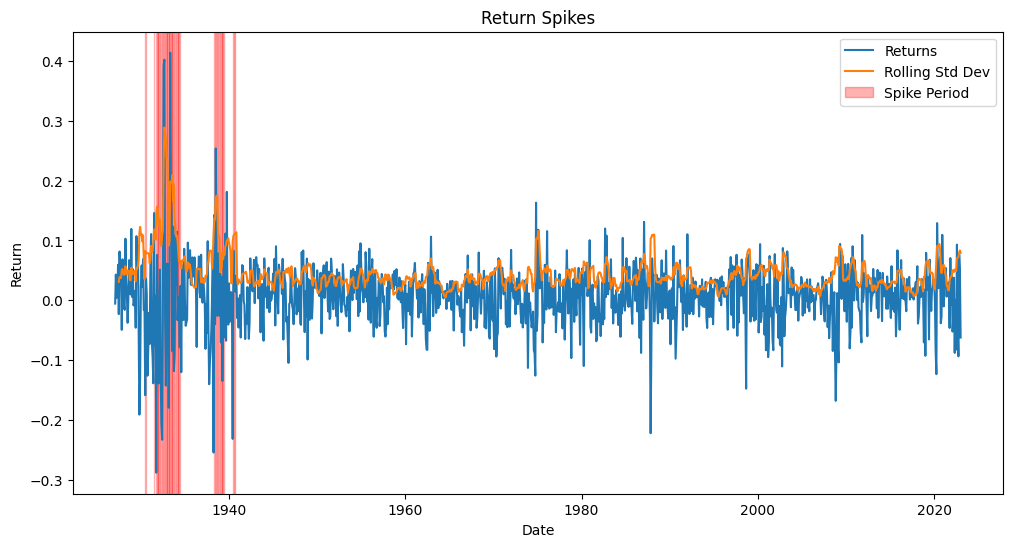

In [ ]:
# Assuming 'R' column represents returns and the index is a datetime index.
def find_spike_periods(df, return_column='R', threshold=2):
    """
    Finds periods of spikes in returns exceeding a given threshold.

    Args:
        DF_FINAL: DataFrame with a datetime index and a return column.
        return_column: The name of the column containing returns.
        threshold: The standard deviation threshold to identify a spike.

    Returns:
        A list of tuples, where each tuple represents a spike period
        (start_date, end_date).
    """

    # Calculate rolling standard deviation to identify volatility
    rolling_std = DF_FINAL[return_column].rolling(window=12).std() # Adjust window size as needed

    # Identify spikes based on threshold
    spikes = DF_FINAL[return_column][rolling_std > threshold * rolling_std.mean()]

    # Group consecutive spikes into periods
    spike_periods = []
    start_date = None
    for date in spikes.index:
        if start_date is None:
            start_date = date
        elif date != spikes.index[spikes.index.get_loc(date) - 1] + pd.DateOffset(months=1): # Adjust for your data freq
            spike_periods.append((start_date, spikes.index[spikes.index.get_loc(date) - 1]))
            start_date = date
    if start_date is not None:
        spike_periods.append((start_date, spikes.index[-1]))

    return spike_periods

# Example usage:
spike_periods = find_spike_periods(DF_FINAL)
print(spike_periods)

# For visualization
plt.figure(figsize=(12, 6))
plt.plot(DF_FINAL['R'], label='Returns')
plt.plot(DF_FINAL['R'].rolling(window=6).std(), label='Rolling Std Dev')

for start, end in spike_periods:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Spike Period' if start==spike_periods[0][0] else '') # Plot each spike as a shaded area
plt.legend()
plt.title('Return Spikes')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()